In [23]:
import os
import sys
sys.path.append('./preproc/code')
sys.path.append("./src")

import numpy as np
import pandas as pd

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Final Report

Developed by

- Sunghwan Moon, Jungmin Kim, Seunghyeon Park, Bojing Gui

GitHub for Full code: [LINK](https://github.com/sunghwanism/FM_for_bio_signal/tree/FMmodel)

## Introduction

### (1) Problem

With the emergence of edge devices such as apple watch and Fit-bit, the use of personalized health data is becoming more prevalent. Therefore, if we can make good use of personalized health data such as biometric signals in edge devices, we will be able to easily monitor our health conditions such as our sleep patterns.

However, due to the nature of edge device and health data, personalized health data cannot be shared with one another and cannot be collected as public open dataset, which limits the learning of a huge quantity of health data. Moreover, since it must be embedded in the edge device model, the size of the personalized model itself is limited.

More specifically, the current Apple watch uses the user's biosignal (ECG, Heart rate, ..) to analyze the user's sleep pattern, but the individual biosignal data can only be owned by Apple, the data collector. In a situation where data access is limited, we aim to build a foundation model that learns the representation of biosignals through the MESA (Multi-Ethnic Study of Atherosclerosis - Sleep Data) dataset, a publicly open biosignal dataset (ECG, Heart rate). The use of such a foundation model enables personalized tasks like individual sleep pattern classification, despite the inability to collect individual biosignal data for model training.

Therefore, we need to build a foundation model that focuses on the following three points.

First, we must be able to utilize information from various types of multimodal biosignals rather than a single biosignal, and we must be able to utilize each signal's information without loss. From this perspective, sufficient consideration for the multimodalities of biosignals is necessary.

Second, the foundation model must be able to be trained in a self-supervised manner. The foundation model requires a large amount of data, and it is very costly to designate labels for biosignals (because it requires the knowledge of medical professionals), so we must assume an environment without labels. In addition, the actual use of labels is to create a specific task-specific model, so it is not appropriate for training a foundation model that should be used for multiple downstream tasks. For this, we need to consider effective self-supervised learning methods for foundation model training.

Third, our foundation model must be able to perform personalized downstream tasks well. Personalized models are trained with individual data stored on each device, and each user's biosignal can vary greatly. In order for the foundation model to work well on each personalized device, the model must be able to learn subject-invariant features that are robust to subject domain shifts.


Our problem setting and following considerations.

*  Existence of multimodalities in bio-signal data
*  Lack of sleep stage classification label in bio signal
*  Downstream task for personalized model

### (2) Related Work

- **FOCAL** Framework [GitHub](https://github.com/tomoyoshki/focal)

    The FOCAL Framework, proposed in [FOCAL: Contrastive Learning for Multimodal Time-Series Sensing Signals in Factorized Orthogonal Latent Space, 2023], is a self-supervised multimodal contrastive framework. And, in this case, not only is shared information between sensory modalities extracted, but exclusive modality information is not explicitly considered, which could be essential to understanding the underlying sensing physics. We intend to integrate subject-aware learning to this strategy.


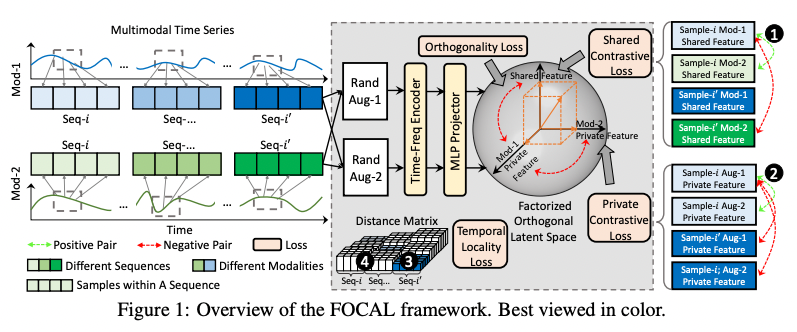

- **Subject-Aware Contrastive Learning for Biosignals** [GitHub](https://github.com/zacharycbrown/ssl_baselines_for_biosignal_feature_extraction)

    This study presents a methodology for dealing with Intersubject variability when learning representations for biosignals. Intersubject variability can be interpreted as a different domain for each subject. The domain shift from subject to subject can be modeled and corrected with adversarial training. Through this adversarial training, the model can also be promoted to learn domain-invariant features. We also used adversarial training to learn subject invariant features in our learning methodology.

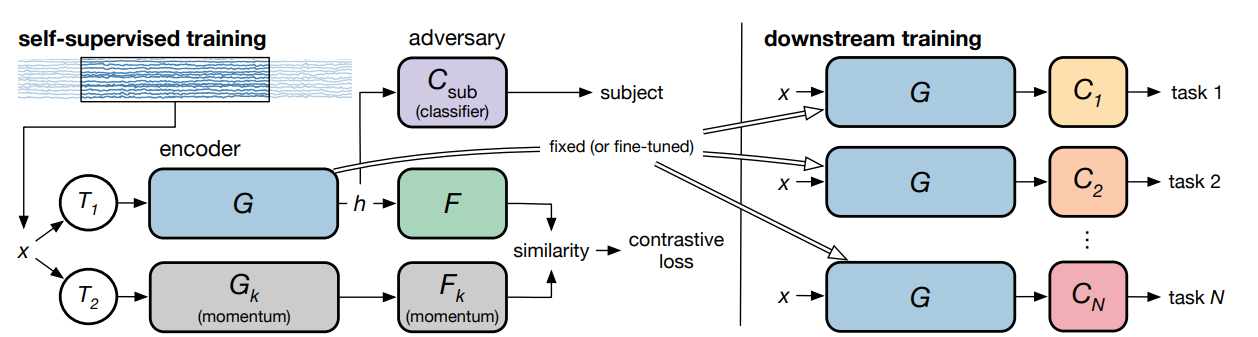

## Method

### (1) Project Overview


In our big overview, we expect that the foundation model generates informative representative feature from large bio-signal dataset, and it can improve the downstream task in the restricted environment where people cannot share bio-signal data with others. To prove the effectiveness of our foundation model, we evaluate the downstream classifier based on our foundation model and compare with other downstream classifier without foundation model.

Specifically, we will attempt to develop the foundation model using bio-signal (ECG, Heart Rate) [1] for applying the sleep stage classification (downstream task) from the personal data of edge devices [2], such as Apple Watch or Fit-bit. It is hard to get high performance by only using personally own data from edge devices and to train the model, as limitation of the amount of data for train and low hardware resources of edge devices. We expect that the foundation model can improve the downstream task in the restricted environment that people cannot share bio-signal data to others.

##### Figure 1
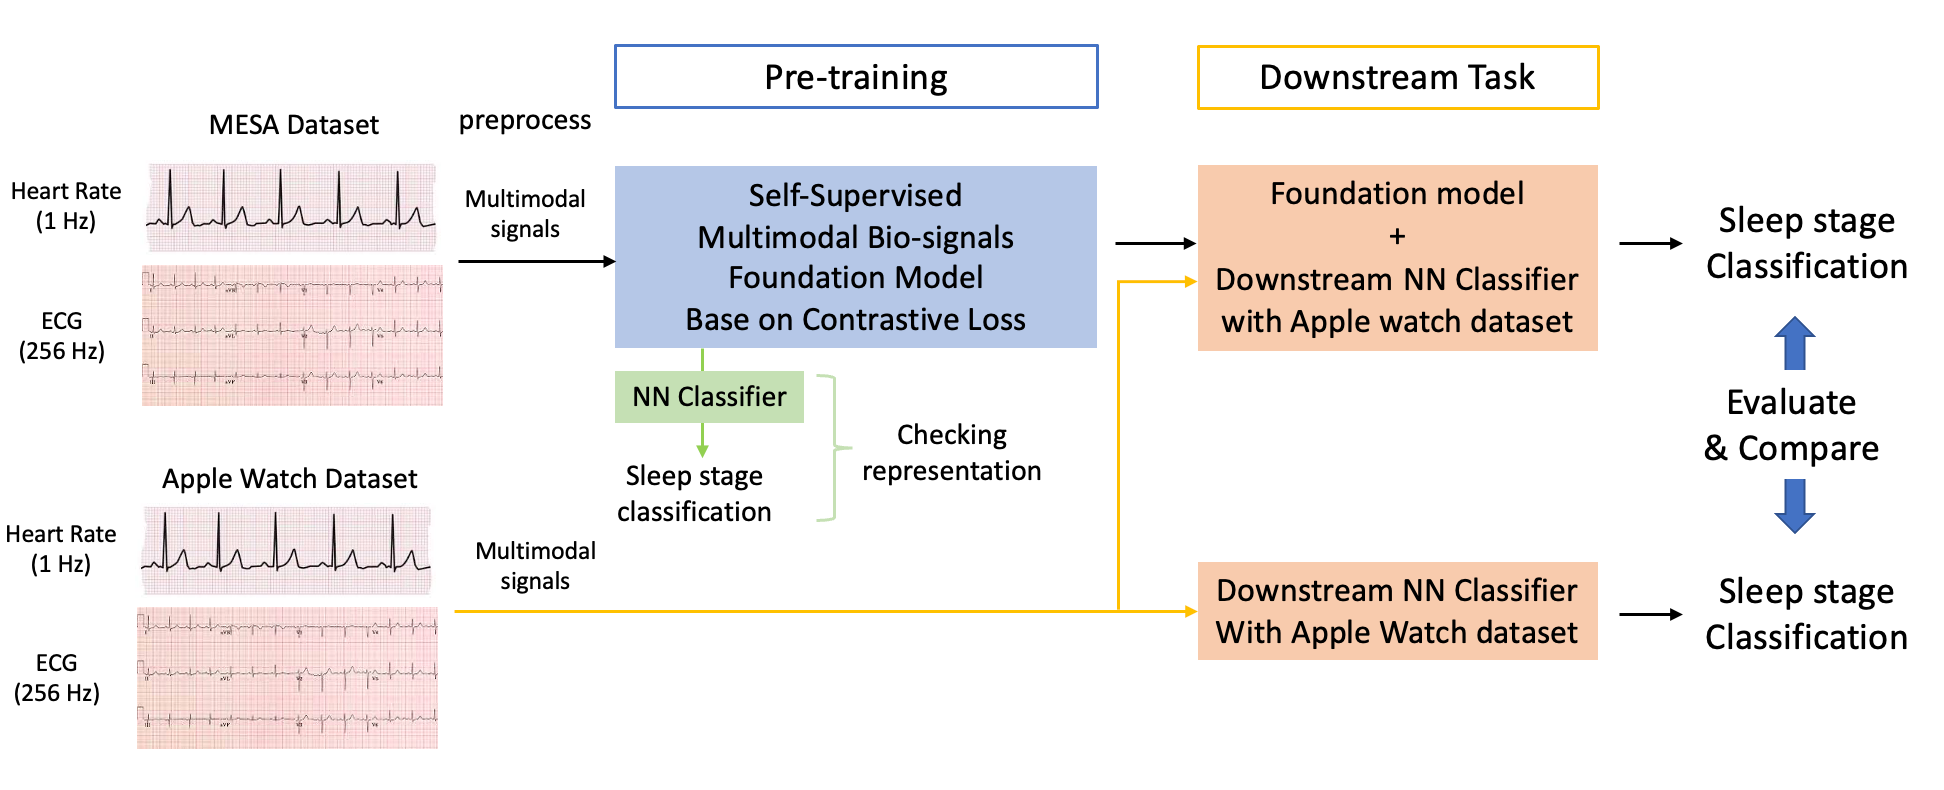

### (2) Foundation Model

We present the issue that the personalized model in the edge device lacks sufficient data to learn each personalized model. We intend to suggest a solution to the problem by creating a foundation model from a huge amount of bio-signal data that has been made public and improving the performance of the personalized model in the edge device using the foundation model. We aim to take into account each of the 3 issues we mentioned in the problem setting, and suggest solutions for each problem below.

*  Existence of multimodalities in bio-signal data -> Multimodal learning
*  Lack of sleep stage classification label in bio signal -> Self-supervised constrastive learning
*  Downstream task for personalized model -> Subject-invariance learning

Previous studies focusing on points each existed, but did not take into account of all the relevant factors essential for the personalized model, so we newly propose the following model satisfiying these points.

##### Figure 2
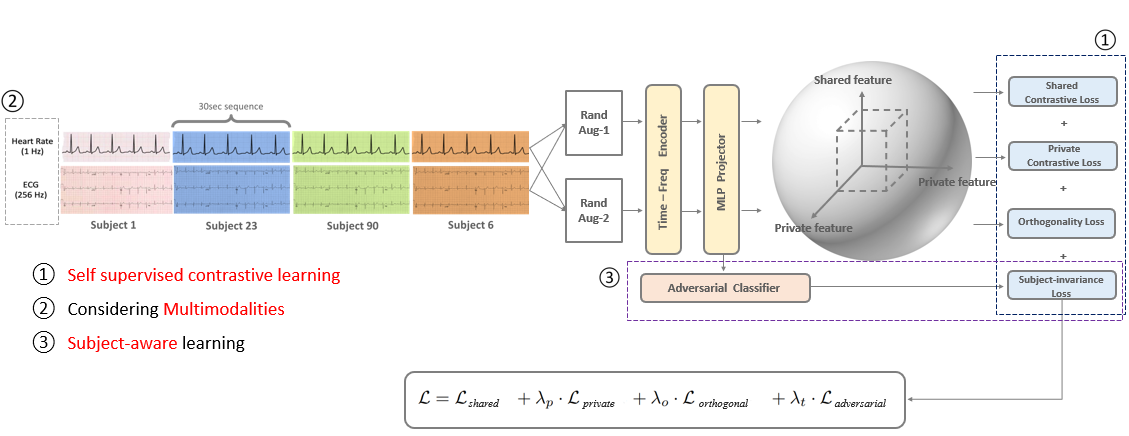

#### 1. Multi Modal Contrastive Learning

We chose the multimodal contrastive framework for learning the signal feature of foundation model. To effectively utilize multimodal information, we borrow the way how FOCAL contrastive learning method handles multimodal sensory data. Previous multimodal contrastive frameworks only used the shared information of sensory modalities, but the FOCAL framework encodes each modality into a factorized latent space consisting of shared features and private features that are orthogonal to each other. The shared space emphasizes feature patterns consistent across sensory modalities through a model-matching objective. In contrast, the private space extracts modality-exclusive information through a transformation invariant objective. By separating shared features and private features, we can proceed with learning that reduces the information loss of multimodal data.

##### 1-A. Contrastive Loss function

Our contrastive loss function consists largely of shared loss, private loss, and orthogonal loss. Projecting each modality embedding into separate shared space and private space while applying the orthogonality constraints avoids the shared information being reused in the private space optimization.

##### Shared loss / Private loss / Othogonal loss

- Shared loss
    - Positive pair : same subject and different modality
    - Negative pair : different subject and different modality

In the shared space, Shared loss encourages feature representations augmented from the 'same subject and different modality' to be closer together in the embedding space (Positive pair), while representation augmented from 'different subject and different modality' are pushed futher apart.

$$
\mathcal{L}_{\text{shared}} = - \sum_{i} \sum_{M_j, M_{j'} \in M, j \neq j'} \log \frac{\exp((h_{ij}^{\text{shared}}, h_{ij'}^{\text{shared}})/\tau)}{\sum_{i' \in B} \exp((h_{ij}^{\text{shared}}, h_{i'j'}^{\text{shared}})/\tau)},
$$

- Private loss
    - Positive pair: different augmentation, same subject and same modality
    - Negative pair: different augmentations, different subjects, and same modality

Private loss encourages feature representations augmented from 'different augmentation, same subject and same modality' to be close together in the embedding space, while representations augmented from 'different augmentations, different subjects, and same modality' are pushed further apart.

$$
\mathcal{L}_{\text{private}} = - \sum_{i} \sum_{M_j \in M} \log \frac{\exp((h_{ij}^{\text{private}}, \tilde{h}_{ij}^{\text{private}})/\tau)}{\sum_{i' \in B, i' \neq i} \exp((h_{ij}^{\text{private}}, h_{i'j}^{\text{private}})/\tau) + \sum_{i' \in B} \exp((h_{ij}^{\text{private}}, \tilde{h}_{i'j}^{\text{private}})/\tau)}.
$$


- Othogonal loss

Orthogonal loss functions to separate the shared feature representation vector from the feature representation vectors of modality 1 and modality 2 in the embedding space, ensuring they are distinct from each other.

$$
\mathcal{L}_{\text{orthogonal}} = \sum_{i} \sum_{M_j \in M} \langle h_{ij}^{\text{shared}}, h_{ij}^{\text{private}} \rangle + \sum_{i} \sum_{M_j, M_{j'} \in M, j \neq j'} \langle h_{ij}^{\text{private}}, h_{ij'}^{\text{private}} \rangle.
$$


##### 1-B. Code: FOCAL module

In [ ]:
class FOCAL(nn.Module):
    def __init__(self, args, backbone):
        """
        dim: feature dimension (default: 256)
        mlp_dim: hidden dimension in MLPs (default: 4096)
        T: softmax temperature (default: 1.0)
        """
        super(FOCAL, self).__init__()

        self.args = args
        self.config = args.focal_config
        self.modalities = args.data_config["modalities"]
        self.backbone = backbone
        self.num_classes = args.downstream_config['num_classes']
        
        self.classifier = nn.Sequential(nn.Linear(self.config["embedding_dim"]*2, self.config["embedding_dim"]),
                                        nn.LeakyReLU(),
                                        nn.Linear(self.config["embedding_dim"], self.config["num_classes"]))
        

    def forward(self, aug1_mod1, aug1_mod2, aug2_mod1, aug2_mod2, proj_head=True, class_head=False):
        """
        Input:
            aug1_mod1: augmented_1 input of the first modality.
            aug1_mod2: augmented_1 input of the second modality.
            aug2_mod1: augmented_2 input of the first modality.
            aug2_mod2: augmented_2 input of the second modality.
        Output:
            mod_features1: Projected mod features of the first augmentation.
            mod_features2: Projected mod features of the second augmentation.
        """
        # compute features

        mod_features1 = self.backbone(aug1_mod1, aug1_mod2, class_head=False, proj_head=proj_head)
        mod_features2 = self.backbone(aug2_mod1, aug2_mod2, class_head=False, proj_head=proj_head)
        
        if class_head:
            features = []
            for modality in self.args.data_config['modalities']:
                features.append(mod_features1[modality])
                # features.append(mod_features2[modality])
            
            concatenated_features = torch.cat(features, dim=1)
            logit = self.classifier(concatenated_features)

            return logit
        else:
            
            return mod_features1, mod_features2


def split_features(mod_features):
    """
    Split the feature into private space and shared space.
    mod_feature: [b, seq, dim], where we use the sequence sampler
    """
    split_mod_features = {}

    for mod in mod_features:
        if mod_features[mod].ndim == 2:
            split_dim = mod_features[mod].shape[1] // 2
            split_mod_features[mod] = {
                "shared": mod_features[mod][:, 0:split_dim],
                "private": mod_features[mod][:, split_dim:],
            }
            
        else:
            b, seq, dim = mod_features[mod].shape
            split_dim = dim // 2
            split_mod_features[mod] = {
                "shared": mod_features[mod][:, :, 0:split_dim],
                "private": mod_features[mod][:, :, split_dim : 2 * split_dim],
            }

    return split_mod_features

##### 1-C. Code: FOCAL loss

In [ ]:
import torch
import torch.nn as nn

from models.FOCALModules import split_features

class FOCALLoss(nn.Module):
    def __init__(self, args):
        super(FOCALLoss, self).__init__()
        self.config = args.focal_config
        self.modalities = args.data_config["modalities"] # return example ['ecg', 'hr']
        self.criterion = nn.CrossEntropyLoss(reduction="mean")
        self.similarity_f = nn.CosineSimilarity(dim=-1)
        self.orthonal_loss_f = nn.CosineEmbeddingLoss(reduction="mean")
        self.temperature = self.config["temperature"]

    def mask_correlated_samples(self, seq_len, batch_size, temporal=False):
        """
        Return a mask where the positive sample locations are 0, negative sample locations are 1.
        """
        if temporal:
            """Extract comparison between sequences, output: [B * Seq, B * Seq]"""
            mask = torch.ones([batch_size, batch_size], dtype=bool).to(self.config.device)
            mask = mask.fill_diagonal_(0)
            mask = mask.repeat_interleave(seq_len, dim=0).repeat_interleave(seq_len, dim=1)
        else:
            """Extract [2N, 2N-2] negative locations from [2N, 2N] matrix, output: [seq, B, B]"""
            N = 2 * batch_size
            diag_mat = torch.eye(batch_size).to(self.config['device'])
            mask = torch.ones((N, N)).to(self.config['device'])

            mask = mask.fill_diagonal_(0)
            mask[0:batch_size, batch_size : 2 * batch_size] -= diag_mat
            mask[batch_size : 2 * batch_size, 0:batch_size] -= diag_mat

            mask = mask.unsqueeze(0).repeat(seq_len, 1, 1).bool()

        return mask

    def forward_contrastive_loss(self, embeddings1, embeddings2, finegrain=False):
        """
        Among sequences, only samples at paired temporal locations are compared.
        embeddings shape: [b, seq, dim]
        """
        # get shape
        batch, dim = embeddings1.shape
        seq = 1
        # Put the compared dimension into the second dimension
        if finegrain:
            """Compare within the sequences, [b, seq, dim]"""
            in_embeddings1 = embeddings1
            in_embeddings2 = embeddings2
            N = 2 * seq
            dim_parallel = batch
            dim_compare = seq
        else:
            """Compare between the sequences, [1, B, dim]"""
            in_embeddings1 = embeddings1.unsqueeze(0)
            in_embeddings2 = embeddings2.unsqueeze(0)
            N = 2 * batch
            dim_parallel = seq
            dim_compare = batch

        # Calculate similarity
        z = torch.cat((in_embeddings1, in_embeddings2), dim=1) # [1, 2B, dim]
        sim = self.similarity_f(z.unsqueeze(2), z.unsqueeze(1)) / self.temperature # [1, 2B, 2B]
        sim_i_j = torch.diagonal(sim, dim_compare, dim1=-2, dim2=-1)
        sim_j_i = torch.diagonal(sim, -dim_compare, dim1=-2, dim2=-1)

        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=1).reshape(dim_parallel, N, 1)
        negative_samples = sim[self.mask_correlated_samples(dim_parallel, dim_compare)].reshape(dim_parallel, N, -1)

        # Compute loss
        labels = torch.zeros(dim_parallel * N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=2).reshape(dim_parallel * N, -1)
        contrastive_loss = self.criterion(logits, labels)

        return contrastive_loss

    def forward_orthogonality_loss(self, embeddings1, embeddings2):
        """
        Compute the orthogonality loss for the modality features. No cross-sample operation is involved.
        input shape: [b, seq_len, dim]
        We use y=-1 to make embedding1 and embedding2 orthogonal.
        """
        # [batch, dim]
        flat_embeddings1 = embeddings1 # .reshape(-1, embeddings2.shape[-1])
        flat_embeddings2 = embeddings2 # .reshape(-1, embeddings2.shape[-1])

        batch = flat_embeddings1.shape[0]
        orthogonal_loss = self.orthonal_loss_f(
            flat_embeddings1,
            flat_embeddings2,
            target=-torch.ones(batch).to(embeddings1.device),
        )

        return orthogonal_loss

    #####################################################################################
    # Adding subject_invaraince_loss in forward function
    # def forward(self, mod_features1, mod_features2, index=None):
    def forward(self, mod_features1, mod_features2, subject_invariance_loss):
    #####################################################################################
        """
        loss = shared contrastive loss + private contrastive loss + orthogonality loss + temporal correlation loss 
        Procedure:
            (1) Split the features into (batch, subsequence, shared/private).
            (2) For each batch, compute the shared contrastive loss between modalities.
            (3) For each batch and modality, compute the private contrastive loss between samples.
            (4) Compute orthogonality loss beween shared-private and private-private representations.
            (5) For each subsequence, compute the temporal correlation loss.
        """
                
        # Step 1: split features into "shared" space and "private" space of each (mod, subsequence), # B, dim
        split_mod_features1 = split_features(mod_features1) # B, dim
        split_mod_features2 = split_features(mod_features2) # B, dim

        # Step 2: shared space contrastive loss
        shared_contrastive_loss = 0

        for split_mod_features in [split_mod_features1, split_mod_features2]:
            for i, mod1 in enumerate(self.modalities):
                for mod2 in self.modalities[i + 1 :]:
                    shared_contrastive_loss += self.forward_contrastive_loss(
                        split_mod_features[mod1]["shared"],
                        split_mod_features[mod2]["shared"],
                    )

        # Step 3: private space contrastive loss
        private_contrastive_loss = 0
        for mod in self.modalities:
            private_contrastive_loss += self.forward_contrastive_loss(
                split_mod_features1[mod]["private"],
                split_mod_features2[mod]["private"],
            )
            
        # Step 4: orthogonality loss
        orthogonality_loss = 0
        for split_mod_features in [split_mod_features1, split_mod_features2]:
            for i, mod in enumerate(self.modalities):
                # orthognoality between shared, private, and temporal space
                orthogonality_loss += self.forward_orthogonality_loss(
                    split_mod_features[mod]["shared"],
                    split_mod_features[mod]["private"],
                )

                # orthogonality between modalities
                for mod2 in self.modalities[i + 1 :]:
                    orthogonality_loss += self.forward_orthogonality_loss(
                        split_mod_features[mod]["private"],
                        split_mod_features[mod2]["private"],
                    )    

        loss = (
            shared_contrastive_loss * self.config["shared_contrastive_loss_weight"]
            + private_contrastive_loss * self.config["private_contrastive_loss_weight"]
            + orthogonality_loss * self.config["orthogonality_loss_weight"]
            + subject_invariance_loss * self.config["subject_invariant_loss_weight"]
        )
        
        return loss

#### 2. Subject-invariant learning

To make the encoder of the Foundation model learn subject invariant features, we use an additional Adversarial classifier. The Adversarial classifier uses the hidden vector, which is the output of the MLP Projector in Figure 2, as input to learn to classify the free label, which is the subject class (information about which subject's signal it is). This Classifier is trained to better distinguish Subjects, and the loss used at this time is named adversarial loss. We used this classifier's loss in reverse to create a subject-Invariance loss for Subject-invariant learning, and added it to the loss function of this FOCAL encoder.

##### 2-A. Adversarial classifier and Adversarial loss

The adversarial classifier is composed of a simple 3 layer feed forward network. The classifier $ C_{\text{sub}} $ is trained to predict the identity of the subject of each example based on latent vector $ h_i $: $ C_{\text{sub}}(h_i) = C_{\text{sub}}(G(x_i)) $. The $ j $-th element, $ C^j (h_i) $, corresponds to the probability of $ h_i $ being from subject $ j $. This model is sub-trained with a fixed encoder $ G $ using cross entropy loss:


$$
\ell_{\text{sub}, i} = - \sum_{i=0}^{N_{\text{sub}} - 1} \mathbb{1}_{j = s_i} \log C^{j}_{\text{sub}}(G(z_i)),
$$


where $ N_{\text{sub}} $ is the number of subjects, $ s_i $ is the subject number of example.


##### 2-B. Subject invariance loss

The encoder $ G $ is encouraged to confuse this subject classifier by using a fixed $ C_{\text{sub}} $ to regularize the training of $ G $ with the regularization term of:


$$
r_{\text{sub}, i} = - \sum_{j=0}^{N_{\text{sub}} - 1} \mathbb{1}_{j = s_i} \log \left(1 - C^{j}_{\text{sub}}(G(z_i))\right).
$$

##### 2-C. Code: Adversarial classifier and Subject invariance loss

In [ ]:
class AdversarialModel(nn.Module):
    def __init__(self, args):
        super(AdversarialModel, self).__init__()
        embedding_dim = args.focal_config['embedding_dim']
        num_subjects = args.subj_invariant_config['num_subjects']
        dropout_rate = args.subj_invariant_config['dropout_rate']
        self.modalities = args.data_config['modalities']
        self.num_subjects = num_subjects
        
        self.fc = nn.Linear(embedding_dim * 4, embedding_dim)  # Assuming concatenation of embeddings
        self.model = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(embedding_dim // 2, embedding_dim // 4),
            nn.LeakyReLU(),
            nn.Linear(embedding_dim // 4, num_subjects),
            nn.Sigmoid()  # Use Softmax for multi-class classification
        )

    def forward(self, embeddings1, embeddings2):
        embeddings1_mod1 = embeddings1[self.modalities[0]] # B, embedding_dim
        embeddings1_mod2 = embeddings1[self.modalities[1]] # B, embedding_dim
        embeddings2_mod1 = embeddings2[self.modalities[0]] # B, embedding_dim
        embeddings2_mod2 = embeddings2[self.modalities[1]] # B, embedding_dim
        
        combined_embeddings = torch.cat((embeddings1_mod1, embeddings1_mod2, embeddings2_mod1, embeddings2_mod2), dim=1)
        embedding = self.fc(combined_embeddings)
        return self.model(embedding)

    def forward_adversarial_loss(self, subject_preds, subject_labels):
        subject_labels = F.one_hot(subject_labels, num_classes=self.num_subjects)
        subject_outs = F.normalize(subject_preds, p=2, dim=1)
        
        BATCH_DIM = 0
        log_noise = 1e-12
        adversarial_loss = 0.
        curr_batch_size = subject_outs.size(BATCH_DIM)

        for i in range(curr_batch_size):
            j = torch.argmax(subject_labels[i, :]) # Get the index of the true class
            adversarial_loss += -1. * torch.log(log_noise + subject_outs[i, j])
        return adversarial_loss

    def forward_subject_invariance_loss(self, subject_preds, subject_labels):
        subject_labels = F.one_hot(subject_labels, num_classes=self.num_subjects)
        subject_outs = F.normalize(subject_preds, p=2, dim=1)

        BATCH_DIM = 0
        log_noise = 1e-12
        subject_invariance_loss = 0.
        curr_batch_size = subject_outs.size(BATCH_DIM)

        for i in range(curr_batch_size):
            j = torch.argmax(subject_labels[i, :])
            subject_invariance_loss += (-1.) * torch.log(log_noise + (1. - subject_outs[i, j]))
        return subject_invariance_loss

#### 3. Final loss

##### 3-A. Final loss function
Final loss = Contrastive loss + Subject Invariance loss

$$
\mathcal{L} = \mathcal{L}_{\text{shared}} + \lambda_p \cdot \mathcal{L}_{\text{private}} + \lambda_o \cdot \mathcal{L}_{\text{orthogonal}} + \lambda_s \cdot \mathcal{L}_{\text{subject}}
$$


##### 3-B. Code: Final loss (from FOCAL loss)

In [ ]:
loss = (
            shared_contrastive_loss * self.config["shared_contrastive_loss_weight"]
            + private_contrastive_loss * self.config["private_contrastive_loss_weight"]
            + orthogonality_loss * self.config["orthogonality_loss_weight"]
            + subject_invariance_loss * self.config["subject_invariant_loss_weight"]
        )

#### 4. Backbone model for contrastive learning

##### 4-A. DeepSense (GitHub)[https://github.com/akaraspt/tinysleepnet]

The backbone model chosen for contrastive learning was based on the Deepsense model ([ref](https://arxiv.org/abs/1611.01942)) and the tinysleepnet model ([ref](https://github.com/akaraspt/tinysleepnet)). These models use convolutional layers followed by LSTM layers, which capture sequential features, to extract biosignal information. The architecture of the model is shown below. 

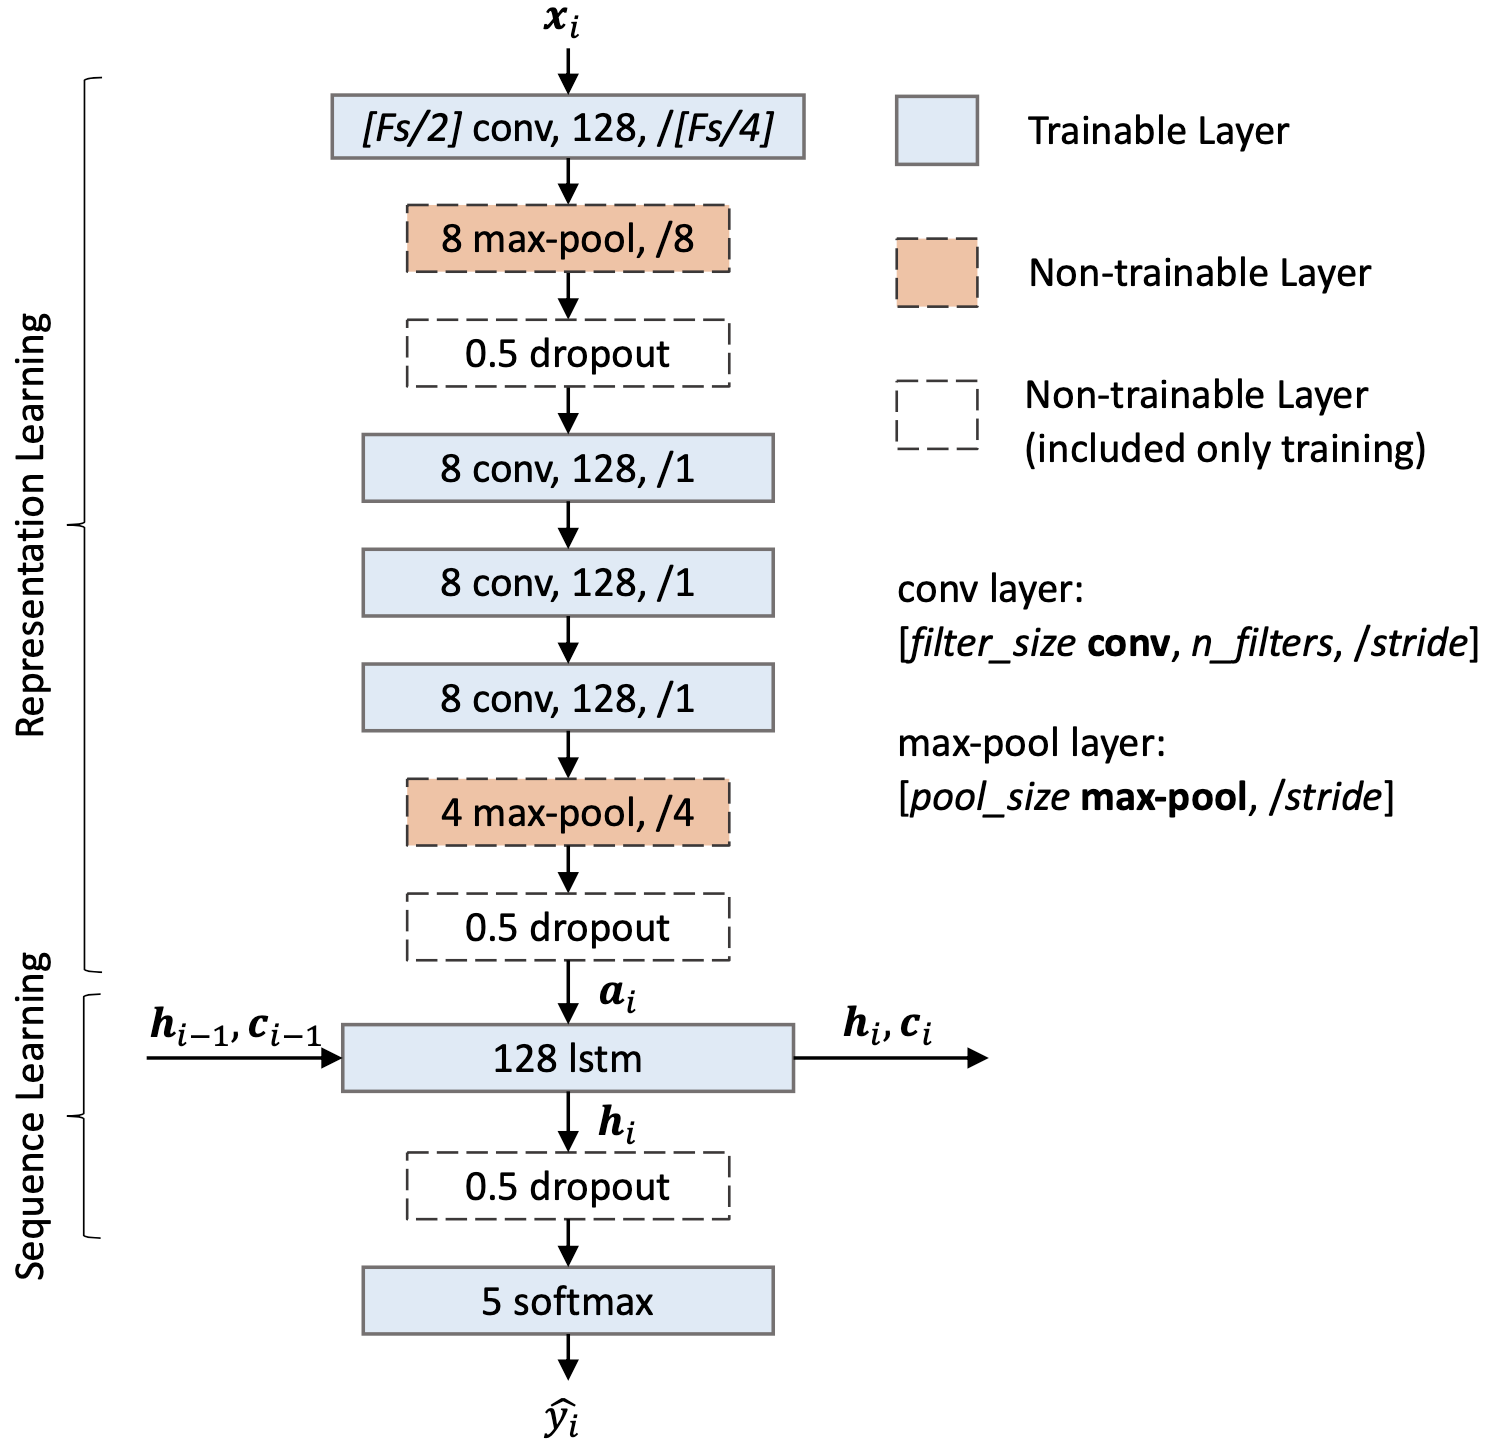

##### 4-B. Code: DeepSense model

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, drop_out=0.5):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(out_channels)
        self.drop_out = nn.Dropout(drop_out)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

class RecurrentBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RecurrentBlock, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
    def forward(self, x):
        """
        x: (Batch, Length, Features)
        """
        x, _ = self.gru(x)
        
        return x

class DeepSense(nn.Module):
    def __init__(self, args):
        super(DeepSense, self).__init__()
        
        self.args = args
        self.config = args.focal_config["backbone"]["DeepSense"]
        self.device = args.focal_config["device"]
        self.modalities = args.data_config["modalities"]
        
        # Intialize the encoder
        self.init_encoder()
        
    def init_encoder(self):
        
        self.sample_dim = self.config["recurrent_dim"] * 2 * len(self.modalities)
        self.modality_extractors = nn.ModuleDict()
        
        dims = []
        num_layers = self.config["num_conv_layers"]
        if num_layers > 0:
            for i in range(num_layers):
                dims.append(int(self.config["conv_dim"]/2**(i+1)))
                
            dims.append(1)
            dims.reverse()
        
        for mod in self.modalities:
            if mod == "ecg":
                if self.config["num_conv_layers"] is None:
                    self.modality_extractors[mod] = ConvBlock(in_channels=1, 
                                                            out_channels=int(self.config["conv_dim"]/2), 
                                                            kernel_size=self.config["mod1_kernel_size"], 
                                                            stride=self.config["mod1_stride"],
                                                            padding=self.config["mod1_padding"],
                                                            drop_out=0
                                                            )
                else:   
                    conv_blocks = []           
                    for i in range(self.config["num_conv_layers"]):
                        conv_blocks.append(ConvBlock(in_channels=dims[i], 
                                                    out_channels=dims[i+1],
                                                    kernel_size=self.config["mod1_kernel_size"], 
                                                    stride=self.config["mod1_stride"],
                                                    padding=self.config["mod1_padding"],
                                                    drop_out=self.config["conv_dropout_rate"],
                                                    ))
                    conv_blocks.append(ConvBlock(in_channels=int(self.config["conv_dim"]/2),
                                                out_channels=self.config["conv_dim"],
                                                kernel_size=self.config["mod1_kernel_size"],
                                                stride=self.config["mod1_stride"],
                                                padding=self.config["mod1_padding"],
                                                drop_out=self.config["conv_dropout_rate"],
                                                ))
                    self.modality_extractors[mod] = nn.Sequential(*conv_blocks)
            else:
                if self.config["num_conv_layers"] is None:
                    self.modality_extractors[mod] = ConvBlock(in_channels=1, 
                                                            out_channels=self.config["conv_dim"], 
                                                            kernel_size=self.config["mod2_ernel_size"], 
                                                            stride=self.config["mod2_stride"],
                                                            padding=self.config["mod2_padding"],
                                                            drop_out=self.config["conv_dropout_rate"],
                                                            )
                else:
                    conv_blocks = []           
                    for i in range(self.config["num_conv_layers"]):
                        conv_blocks.append(ConvBlock(in_channels=dims[i], 
                                                    out_channels=dims[i+1],
                                                    kernel_size=self.config["mod2_kernel_size"], 
                                                    stride=self.config["mod2_stride"],
                                                    padding=self.config["mod2_padding"],
                                                    drop_out=self.config["conv_dropout_rate"],
                                                    ))
                    conv_blocks.append(ConvBlock(in_channels=int(self.config["conv_dim"]/2),
                                                out_channels=self.config["conv_dim"],
                                                kernel_size=self.config["mod2_kernel_size"],
                                                stride=self.config["mod2_stride"],
                                                padding=self.config["mod2_padding"],
                                                drop_out=self.config["conv_dropout_rate"],
                                                ))
                    self.modality_extractors[mod] = nn.Sequential(*conv_blocks)
                    
            
            # print(f"{mod} extractor is initialized.")
                    
        # Setting GRU
        
        self.recurrent_layer = nn.ModuleDict()
        for mod in self.modalities:
            self.recurrent_layer[mod] = RecurrentBlock(input_size=self.config["conv_dim"], 
                                                        hidden_size=self.config["recurrent_dim"], 
                                                        num_layers=self.config["num_recurrent_layers"])
            
            # print(f"{mod} recurrent layer is initialized.")
            
        
        self.class_layer = nn.Sequential(nn.Linear(self.config["class_in_dim"], self.config["fc_dim"]),
                                        nn.GELU(),
                                        nn.Linear(self.config["fc_dim"], self.config["num_classes"]))
        
        out_dim = self.args.focal_config["embedding_dim"]
        self.mod_projectors = nn.ModuleDict()
        
        
        for mod in self.modalities:
            if mod == "ecg":
                self.mod_projectors[mod] = nn.Sequential(
                nn.Linear(self.config['mod1_linear_dim'], self.config["recurrent_dim"] * 2), # To-do: calculate the linear dim automatically
                nn.Dropout(self.config["proj_dropout_rate"]),
                nn.Linear(self.config["recurrent_dim"] * 2, out_dim),
                nn.ReLU(),
                nn.Linear(out_dim, out_dim),
            )
            else:
                self.mod_projectors[mod] = nn.Sequential(
                    nn.Linear(self.config['mod2_linear_dim'], self.config["recurrent_dim"] * 2), # To-do: calculate the linear dim automatically
                    nn.Dropout(self.config["proj_dropout_rate"]),
                    nn.Linear(self.config["recurrent_dim"] * 2, out_dim),
                    nn.ReLU(),
                    nn.Linear(out_dim, out_dim),
                )
        
        print("** Finished Initializing DeepSense Backbone **")
        

    def forward_encoder(self, mod1, mod2, class_head=True, proj_head=False):
        """
        mod1: (Batch length) -> after augmentation
        mod2: (Batch length) -> after augmentaiton
        Augmentation is applied with same method for both modalities.
        """
        # Adding channel dimension: (Batch length) -> (Bacth channel(1) length)
        mod1 = mod1.unsqueeze(1)
        mod2 = mod2.unsqueeze(1)
        
        mod_name_1 = self.args.data_config["modalities"][0]
        mod_name_2 = self.args.data_config["modalities"][1]
        
        # Pass through modality extractors (CNN)
        modality_1_features = self.modality_extractors[mod_name_1](mod1)
        modality_2_features = self.modality_extractors[mod_name_2](mod2)
        
        # print(f"mod1 cnn feature shape: {modality_1_features.shape}", f"mod2 cnn feature shape: {modality_2_features.shape}")
    
        # (Batch, Features, Length) -> (Batch, Length, Features)
        modality_1_features = modality_1_features.transpose(1,2)
        modality_2_features = modality_2_features.transpose(1,2)
        
        # Pass through GRU
        recurrent_1 = self.recurrent_layer[mod_name_1](modality_1_features).flatten(start_dim=1)
        recurrent_2 = self.recurrent_layer[mod_name_2](modality_2_features).flatten(start_dim=1)
        
        
        # print(f"mod1 rnn feature shape: {recurrent_1.shape}", f"mod2 rnn feature shape: {recurrent_2.shape}")
        modality_features = [recurrent_1, recurrent_2]
        
        if not class_head:
            if proj_head:
                sample_features = {}
                for i, mod in enumerate(self.modalities):
                    sample_features[mod] = self.mod_projectors[mod](modality_features[i])
                    
                return sample_features
            
            else:
                return dict(zip(self.modalities, modality_features))
        
        else:
            sample_features = torch.cat(modality_features, dim=1)
            logits = self.class_layer(sample_features)
            
            return logits
        
    
    def forward(self, mod1, mod2, class_head=False, proj_head=True):
        if class_head:
            """Finetuning the classifier"""
            logits = self.forward_encoder(mod1, mod2, class_head)
            return logits
        
        else:
            """Pretraining the framework"""
            enc_mod_features = self.forward_encoder(mod1, mod2, class_head, proj_head)
            
            return enc_mod_features

### (3) Downstream model

#### 1. Baseline: DeepSense model

DeepSense model explained as a backbone model above will be used as the baseline comparison for our model. The neural network will take in the two inputs, heart rate and ECG. The ECG will be processed through convolutional layers and a LSTM before the inputs are concatenated and fully connected layers are used for classification.

#### 2. Classifier With Foundation Model

We use feed forward network for foundation downstream classifier. Belows are code for the classifier.

In [ ]:
class SleepStageClassifier(nn.Module):
    def __init__(self, args):
        super(SleepStageClassifier, self).__init__()
        self.args = args
        self.num_classes = args.downstream_config['num_classes']
        self.embedding_dim = args.downstream_config['embedding_dim']
        
        # Define the classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.embedding_dim * 4, 128),  # Concatenated features from 4 inputs
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, self.num_classes)
        )
        
    def forward(self, enc_feature_1, enc_feature_2):
        
        features = []
        for modality in self.args.data_config['modalities']:
            features.append(enc_feature_1[modality])
            features.append(enc_feature_2[modality])
        
        concatenated_features = torch.cat(features, dim=1)
        out = self.classifier(concatenated_features)
        
        return out

## Experiment

### 1. Dataset

We used 356,062 samples from the public MESA data set, which contained 125 subjects out of 6,814. And we chose electrocardiogram (ECG) and heart rate as modalities because we could only obtain those two from the Apple Watch data. Additionally, in order to complete our downstream assignment, we gathered each friend's unique Apple Watch dataset. For our contrastive learning, we created a subject segment pair and divided the data into portions of 100 by 25 by 25.

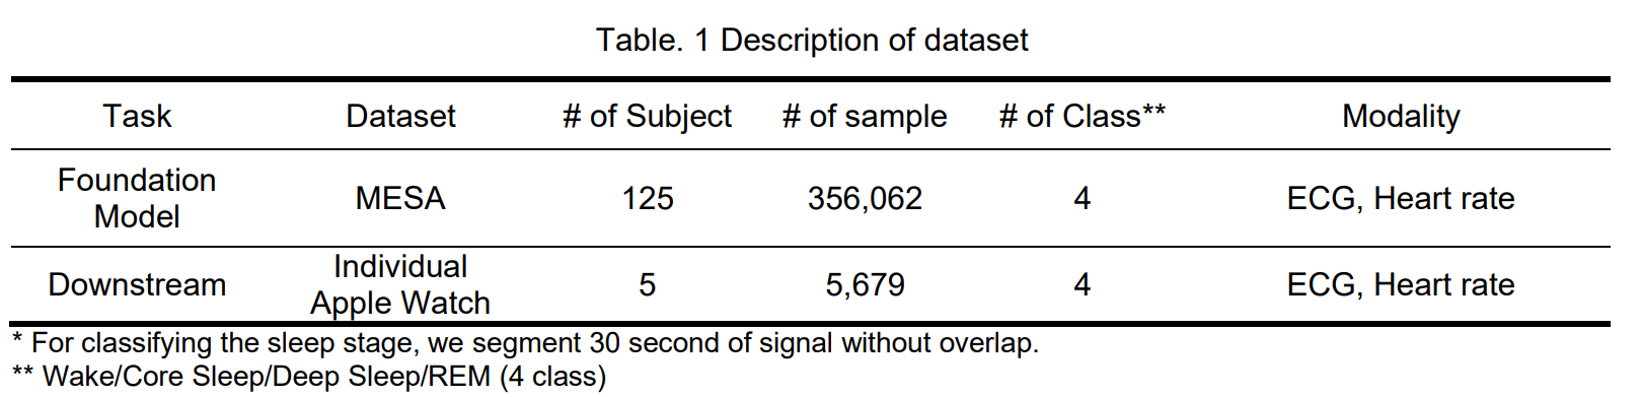

### 2. Preprocessing

#### 2-1 Preprocessing MESA
- Since the 30 second data of the signal determines the sleep state in the downstream task, we had to segment the bio signal (heart rate and electrocardiogram) to 30 seconds (1 epoch).
- We selected validation epoch that did not have any issues, such as disconnection errors or mis-collection times between bio signals.
- We preprocessed each of the bio signals (Heart Rate & ECG) like below

- **Heart Rate**
    - After selecting the validation epoch, the heart rate was **interpolated** to have a value every 1 second, **smoothed** and **filtered** to amplify periods of high change by convoloving with a Gaussian filter difference
    
    - It was then **normalized** by dividing by the 90th percentile of the absolute difference between each heart rate measurement and the mean heart rate during the sleep periods
    
- **Electrocardiogram (ECG=EKG)**
    - After selecting the validation epoch, the ECG was **smoothed** and **filtered** with Gaussian filter to denoise it

In [ ]:
from apple import generate_data_to_dic, filter_to_epoch
from mesa import mesa_preprocessing, get_subject_ids

In [ ]:
DATAPATH = None # For privay reasons, the path to the data is not provided
subject_ids = get_subject_ids(PATH=os.path.join(DATAPATH, "./mesa/polysomnography/annotations-events-nsrr"))
len(subject_ids)

SAVEPATH= None # For privay reasons, the path to the data is not provided
Error = mesa_preprocessing(subject_ids, savepath=SAVEPATH)

In [ ]:
csv_datapath = None # For privay reasons, the path to the data is not provided

for subj in subject_ids:

    if subj not in Error:
        activity = np.load(SAVEPATH+subj+"_activity_count.npy").reshape(-1)
        hr = np.load(SAVEPATH+subj+"_heart_rate.npy").reshape(-1)
        ecg = np.load(SAVEPATH+subj+"_ecg.npy").reshape(-1)
        ecg = -ecg
        psg_status = np.load(SAVEPATH+subj+"_labeled_sleep.npy").squeeze()
        repeat_psg = []
        repeat_cosine = []
        session = []
        session_ecg = []
        psg_ecg = []

        ses = 0

        for i, psg in enumerate(psg_status):
            repeat_psg.extend([psg]*30)            
            session.extend([ses]*30)
            session_ecg.extend([ses]*256)
            psg_ecg.extend([psg]*256)
            
            ses += 1

        print(np.array(activity).shape, np.array(hr).shape, np.array(ecg).shape, len(repeat_psg), len(psg_ecg), len(session_ecg))

        df = pd.DataFrame({'activity_count': activity, 'heart_rate': hr, 'session_id':session, 'psg_status': repeat_psg})
        df_ecg = pd.DataFrame({"ECG":ecg, 'session_id':session_ecg, 'psg_status': psg_ecg})
        
        df.to_csv(csv_datapath, index=False)
        df_ecg.to_csv(csv_datapath, index=False)

After the preprocessing, we filtered **1,405 subjects** among 2,056 after quality contorl and, finally, we select **100 subjects** for training our foundation model.
The total segments we used is 356,062 (1 epoch during 30s).

Below image show the result of preprocessing on **subject0001** from MESA dataset

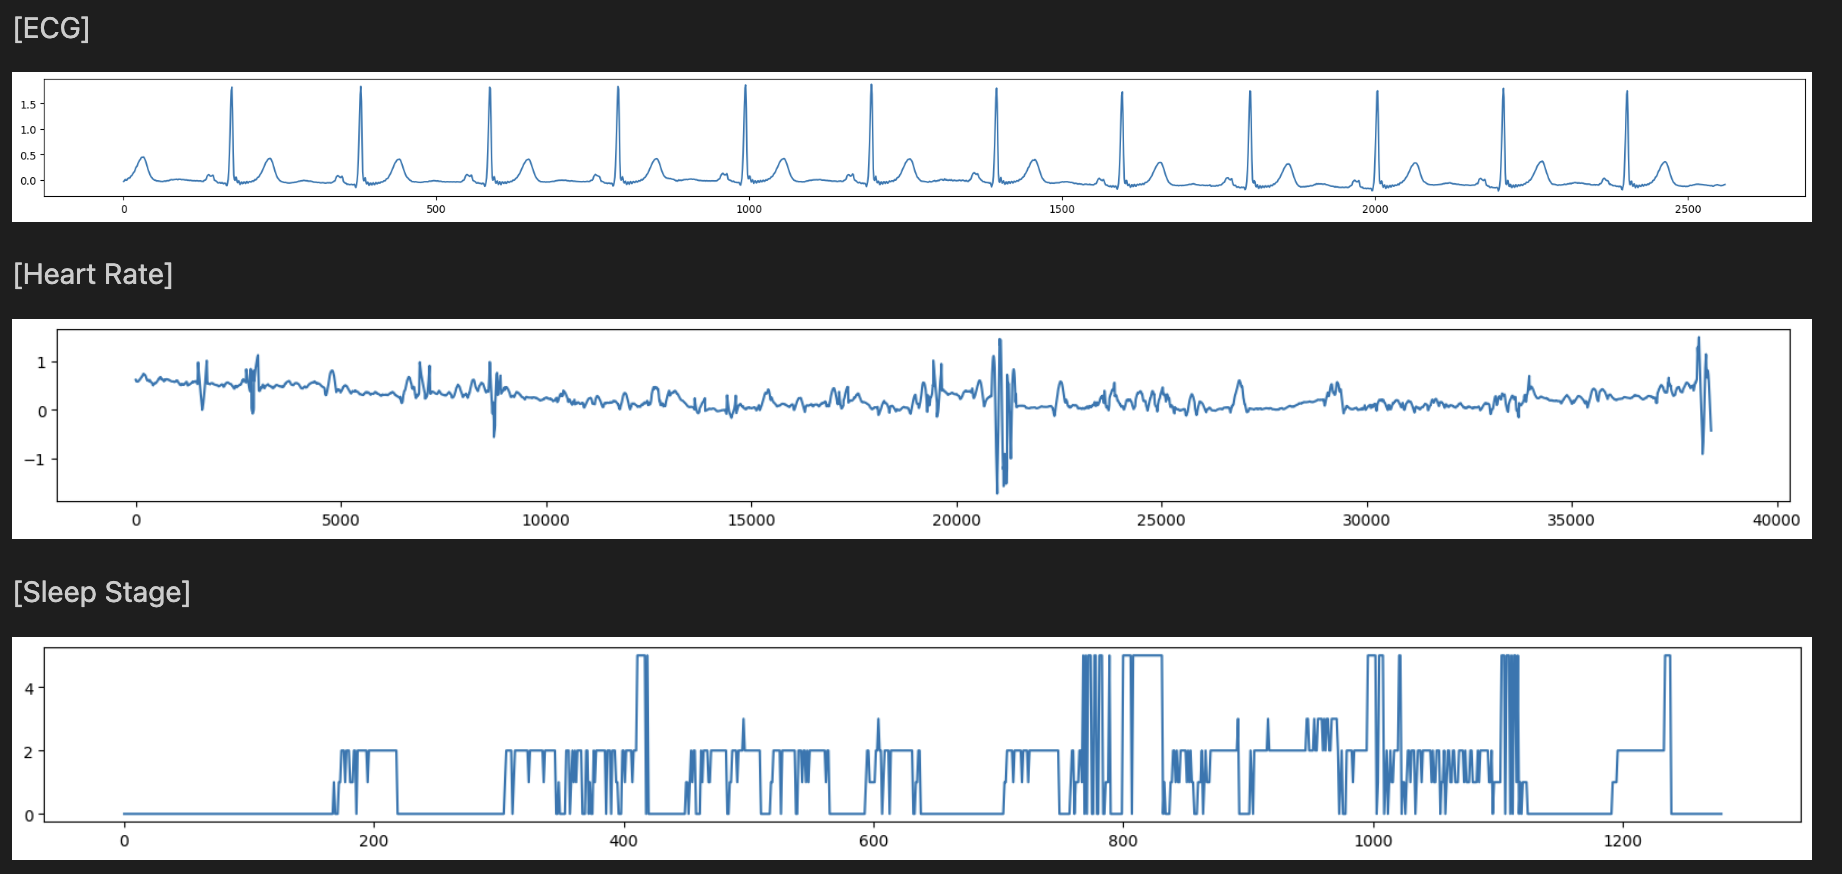

#### 2-2 Preprocessing Apple watch

- We collected 5 real Apple watch dataset, which included heart rate and ECG.
- We intented to collect each data with 7 day length and among them, only data without problems like disconnection errors or mis-collection times between bio signals were used.
- We preprocessed it in accordance with the previous study "**Sleep stage prediction with raw acceleration and photoplethysmography heart rate data derived from a consumer wearable device** (Olivia, et al.)"
- The preprocessing pipeline is idential with the MESA dataset part

In [ ]:
PATH = None # For privay reasons, the path to the data is not provided

subject_ids = []
for n, filename in enumerate(os.listdir(PATH)):
    filename = filename.split('_')
    subject_id = int(filename[0])

    if subject_id not in subject_ids:
        subject_ids.append(subject_id)
    
# sort the list
sorted_subject_ids = sorted(subject_ids)
np.array(sorted_subject_ids)

In [ ]:
save_path = None # For privay reasons, the path to the data is not provided

apple_data = generate_data_to_dic(PATH,
                                  second_column_step=1,val_to_fill_nans=-100,
                                  print_analysis=False)


for subj in sorted_subject_ids:
    savepath = "../data/watch/processed/temp/subject_" + str(subj) + ".csv"
    apple_data[subj].to_csv(savepath, index=False)


df, psg_status = filter_to_epoch("../data/watch/processed/temp/", bin_size=30)

for subj in sorted_subject_ids:
    ses_id = psg_status[subj].keys()
    last_ses = list(ses_id)[-1]
    stage = psg_status[subj].values()
    
    temp = pd.DataFrame({'session_id': ses_id, 'new_psg_status': stage})
    
    new_df = pd.merge(df[subj], temp, on='session_id')
    new_df.drop(columns=["psg_status"], inplace=True)
    
    new_df.rename(columns={'new_psg_status': 'psg_status'}, inplace=True)
    
    last_info = new_df[new_df['session_id'] == last_ses]
    
    if len(last_info) != 30:
        new_df.drop(new_df[new_df['session_id'] == last_ses].index, inplace=True)
    
    savepath = save_path + str(subj) + ".csv"
    new_df.to_csv(savepath, index=False)

##### 2-2 Generating Pair dataset for Contrastive Learning

In [ ]:
data_directory = None # For privay reasons, the path to the data is not provided
save_dir = None # For privay reasons, the path to the data is not provided

datas = os.listdir(data_directory)
datas.sort()
datas = datas[:4*100]
ecg_datas = [data for data in datas if 'ecg' in data]
hr_datas = [data for data in datas if 'heart_rate' in data]
sleep_datas = [data for data in datas if 'sleep' in data]
act_datas = [data for data in datas if 'activity' in data]

subj_data = {'ecg':ecg_datas, 'hr': hr_datas, 'stage':sleep_datas, 'act':act_datas}

In [ ]:
def make_pair(ecg, hr, sleep, act, subject_idx, subject_id, savepath):

    for seg_idx in range(len(sleep)):

        ecg_data = ecg.squeeze()[seg_idx]
        hr_data = hr.squeeze()[seg_idx]
        sleep_data = sleep.squeeze()[seg_idx]
        act_data = act.squeeze()[seg_idx]

        data_dict = {
                    'ecg': ecg_data,
                    'hr': hr_data,
                    'stage': sleep_data,
                    'activty': act_data,
                    'subject_idx': subject_idx
                    }
        
        savepath = os.path.join(save_dir, f'{subject_id}_{seg_idx}.npz')
        np.savez(savepath, **data_dict)

In [ ]:
for i in tqdm(range(100)):

    ecg = subj_data['ecg'][i]
    hr = subj_data['hr'][i]
    sleep = subj_data['stage'][i]
    act = subj_data['act'][i]
    
    ecg_list = np.load(os.path.join(data_directory, ecg))
    hr_list = np.load(os.path.join(data_directory, hr))
    sleep_list = np.load(os.path.join(data_directory, sleep))
    act_list = np.load(os.path.join(data_directory, act))
    real_subject = ecg.split('_')[0]

    make_pair(ecg_list, hr_list, sleep_list, act_list, i, real_subject, save_dir)

#### 2-3 Generating Data Pair

- In order to incorporate the previously preprocessed information into our foundation model, we created a **pair** of the ECG and heart rate datasets.

- That is, a single sequence of ECG data and heart rate data corresponded to to a 30-second data collected simultaneously.

- This is because, when designed in this manner, shared contrast loss and private contrast loss between the two modalities can be acquired as intended, as well as subject variance loss by combining the two modalities.

- After configuring the data pair, the sequence was randomly shuffled in order to guarantee that the data was as subject-invariant as possible.

### 3. Training

#### (1) Training Foundation Model

In [ ]:
sys.path.append('./src/foundation')
import os
import sys
sys.path.append('./')

import args
import datetime
from tqdm import tqdm

import torch
import numpy as np
from models.AdversarialModel import AdversarialModel
from models.FOCALModules import FOCAL
from models.loss import FOCALLoss
from models.Backbone import DeepSense
from trainutils.metric import save_metrics

from data.Dataset import MESAPairDataset
from data.Augmentaion import init_augmenter

##### Function of Training

In [ ]:
def train_SA_Focal(train_loader, valid_loader, model, advs_model, 
                   optimizer, advs_optimizer, focal_loss_fn, args):
    torch.manual_seed(args.SEED)
    torch.cuda.manual_seed(args.SEED)
    torch.cuda.manual_seed_all(args.SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    start_time = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    model_save_dir = args.trainer_config["model_save_dir"]
    model_save_dir = os.path.join(model_save_dir, start_time)
    
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

    trainer_config = args.trainer_config
    log_save_dir = args.trainer_config["log_save_dir"]
    
    model_save_format = args.model_save_format
    model_save_format["focal_config"] = args.focal_config
    model_save_format['subj_invariant_config'] = args.subj_invariant_config
    model_save_format['trainer_config'] = args.trainer_config
    model_save_format['data_config'] = args.data_config
    
    aug_1_name = args.data_config['augmentation'][0]
    aug_1_config = args.data_config['augmenter_config'].get(aug_1_name, {})
    aug_2_name = args.data_config['augmentation'][1]
    aug_2_config = args.data_config['augmenter_config'].get(aug_2_name, {})
    
    aug_1 = init_augmenter(aug_1_name, aug_1_config)
    aug_2 = init_augmenter(aug_2_name, aug_2_config)
    
    model.train()
    best_val_loss = float('inf')
    
    train_focal_losses, val_focal_losses = [], []
    train_advs_losses = []
    train_accuracies = []
    
    for ep in tqdm(range(trainer_config['epochs'])):
        
        model.train()
        advs_model.train()
        focal_loss_fn.train()
        
        # Save Result
        focal_train_loss = 0
        running_advs_train_loss = 0
        
        correct_preds = 0
        total_preds = 0
        
        
        for raw_modal_1, raw_modal_2, subj_label, sleep_label in train_loader:
            raw_modal_1, raw_modal_2, subj_label, sleep_label = raw_modal_1.to(args.focal_config["device"]), raw_modal_2.to(args.focal_config["device"]), subj_label.to(args.focal_config["device"]), sleep_label.to(args.focal_config["device"]) # [B, 30], [B, 30*256], [B, 1]
            
            aug_1_modal_1 = aug_1(raw_modal_1)
            aug_2_modal_1 = aug_2(raw_modal_1)
            
            aug_1_modal_2 = aug_1(raw_modal_2)
            aug_2_modal_2 = aug_2(raw_modal_2)
            
            # For updating the only advs_model (classifier)
            for param in model.parameters():
                param.requires_grad = False
            for param in advs_model.parameters():
                param.requires_grad = True
                
            advs_optimizer.zero_grad()
            
            # Using Encoder for classify the subject
            enc_feature_1, enc_feature_2 = model(aug_1_modal_1, aug_1_modal_2, aug_2_modal_1, aug_2_modal_2, proj_head=True)
            
            # Predict the subject
            subj_pred = advs_model(enc_feature_1, enc_feature_2) 
            advs_loss = advs_model.forward_adversarial_loss(subj_pred, subj_label)
            
            advs_loss.backward()
            advs_optimizer.step()
            
            running_advs_train_loss += advs_loss.item()
            
            # For efficient memory management
            del enc_feature_1, enc_feature_2, subj_pred, advs_loss
            
            # For updating the only Focal model (SSL model)
            for param in model.parameters():
                param.requires_grad = True
            for param in advs_model.parameters():
                param.requires_grad = False
            
            optimizer.zero_grad()

            enc_feature_1, enc_feature_2 = model(aug_1_modal_1, aug_1_modal_2, aug_2_modal_1, aug_2_modal_2, proj_head=True)
            
            subj_pred = advs_model(enc_feature_1, enc_feature_2) 
            subj_invariant_loss = advs_model.forward_subject_invariance_loss(subj_pred, subj_label)
            
            focal_loss = focal_loss_fn(enc_feature_1, enc_feature_2, subj_invariant_loss) # To-Do -> add regularization term about subject invariant
            focal_loss.backward()
            optimizer.step()
            
            focal_train_loss += focal_loss.item()
            
            # Calculate accuracy
            preds = torch.argmax(subj_pred, dim=1)
            correct_preds += (preds == subj_label).sum().item()
            total_preds += subj_label.size(0)
            
            # For efficient memory management
            del enc_feature_1, enc_feature_2, subj_pred, focal_loss
            torch.cuda.empty_cache()
            
        # Calculate and store train accuracy and losses for plotting
        train_accuracy = correct_preds / total_preds
        train_accuracies.append(train_accuracy)
        train_advs_losses.append(running_advs_train_loss / len(train_loader))
        train_focal_losses.append(focal_train_loss / len(train_loader))
        
        print(f"Epoch {ep} - Adversarial Loss: {running_advs_train_loss / len(train_loader)}, \
            Focal Loss: {focal_train_loss / len(train_loader)}, Accuracy: {train_accuracy}")
                
        if ep % trainer_config['val_interval'] == 0:
            model.eval()
            advs_model.eval()
            focal_loss_fn.eval()
            
            focal_val_loss = 0
            
            for raw_modal_1, raw_modal_2, subj_label, sleep_label in valid_loader:
                raw_modal_1, raw_modal_2, subj_label, sleep_label = raw_modal_1.to(args.focal_config["device"]), raw_modal_2.to(args.focal_config["device"]), \
                                                                    subj_label.to(args.focal_config["device"]), sleep_label.to(args.focal_config["device"])
                
                with torch.no_grad():
                    enc_feature_1, enc_feature_2 = model(raw_modal_1, raw_modal_2, raw_modal_1, raw_modal_2, proj_head=True)                    
                    focal_loss = focal_loss_fn(enc_feature_1, enc_feature_2, 0) # To-Do -> add regularization term about subject invariant
                    focal_val_loss += focal_loss.item()
                    
                    # For efficient memory management
                    del enc_feature_1, enc_feature_2, focal_loss
                    torch.cuda.empty_cache()
                    
            print("-----"*20)
            print(f"(Validation) Epoch{ep} - Focal Loss: {focal_val_loss/ len(valid_loader)}")                    
            
            val_focal_losses.append(focal_val_loss / len(valid_loader))
                            
            if focal_val_loss < best_val_loss:
                best_val_loss = focal_val_loss
                
                time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                focal_model_checkpoint = os.path.join(model_save_dir, f'SSL_focal_model_ep_{ep}.pth')
                
                # Save ckpt & arguments
                model_save_format["train_acc"] = train_accuracy
                model_save_format["train_loss"] = focal_train_loss / len(train_loader)
                model_save_format["val_loss"] = focal_val_loss / len(valid_loader)
                model_save_format["train_epoch"] = ep
                model_save_format["focalmodel_path"] = focal_model_checkpoint
                model_save_format["focal_state_dict"] = model.state_dict()
                model_save_format['advs_state_dict'] = advs_model.state_dict()
                
                torch.save(model_save_format, focal_model_checkpoint)                
                
                print(f"Model Saved - Focal Model: {focal_model_checkpoint}")
            print("-----"*20)
    
    LOGPATH = os.path.join(args.trainer_config["log_save_dir"], f'SSL_focal_log_{start_time}.npz')
    train_log = np.array([train_focal_losses, val_focal_losses, train_accuracies, train_advs_losses])
    np.savez(LOGPATH, train_log)
    
    save_metrics(train_focal_losses, val_focal_losses, train_accuracies, train_advs_losses, start_time)
                
def print_args(args):
    
    print("Data Configs:")
    for k, v in args.data_config.items():
        print(f"\t{k}: {v}")
    print("----------"*10)
    
    print("Focal Configs:")
    for k, v in args.focal_config.items():
        print(f"\t{k}: {v}")
    print("----------"*10)
    
    print("Subject Invariant Configs:")
    for k, v in args.subj_invariant_config.items():
        print(f"\t{k}: {v}")
    print("----------"*10)
    
    print("Trainer Configs:")
    for k, v in args.trainer_config.items():
        print(f"\t{k}: {v}")
    print("----------"*10)

##### Generate DataLoader

In [ ]:
print_args(args)

train_dataset = MESAPairDataset(file_path=args.data_config['train_data_dir'],
                                modalities=args.data_config['modalities'],
                                subject_idx=args.data_config['subject_key'],
                                stage=args.data_config['label_key'])
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                            batch_size=args.trainer_config['batch_size'],
                                            shuffle=True,
                                            num_workers=4)

val_dataset = MESAPairDataset(file_path=args.data_config['val_data_dir'],
                                modalities=args.data_config['modalities'],
                                subject_idx=args.data_config['subject_key'],
                                stage=args.data_config['label_key'])

val_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=args.trainer_config['batch_size']//3,
                                            shuffle=False,
                                            num_workers=2)

print("****** Successfully Dataset ******")

##### Training the Foundation Model

In [ ]:
advs_model = AdversarialModel(args).to(args.subj_invariant_config["device"])
advs_optimizer = torch.optim.Adam(advs_model.parameters(), lr=args.subj_invariant_config['lr'])
print("****** Complete Loading the Adversarial Model ******")


if str(list(args.focal_config["backbone"].keys())[0]) == "DeepSense":
    backbone = DeepSense(args).to(args.focal_config["device"])
    
else:
    raise ValueError("Not Supported Backbone")

focal_model = FOCAL(args, backbone).to(args.focal_config["device"])
focal_optimizer = torch.optim.Adam(focal_model.parameters(), lr=args.focal_config["lr"])
focal_loss_fn = FOCALLoss(args)
print("****** Complete Loading the FOCAL Model ******")

print("Start Training SA Focal Model")


train_SA_Focal(train_loader, val_loader, focal_model, advs_model,
                focal_optimizer, advs_optimizer, focal_loss_fn, args)

print("Finished Training SA Focal Model")

#### (2) Training Basemodel

In [ ]:
sys.path.append("./basemodel")

import torch
from torch.utils.data import Dataset

from datetime import datetime

import baselineargs as args
from DeepSense import DeepSense

torch.manual_seed(args.SEED)
torch.cuda.manual_seed(args.SEED)
torch.cuda.manual_seed_all(args.SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
start_time = datetime.now().strftime("%Y%m%d_%H%M%S")

data_config = args.data_config
model_config = args.trainer_config
model_save_format = args.model_save_format

model_save_format["trainer_config"] = model_config
model_save_format["data_config"] = data_config

In [ ]:
class AppleDataset(Dataset):
    def __init__(self, file_path, modalities=['ecg', 'hr'], subject_idx='subject_idx', stage='stage'):
        super(AppleDataset, self).__init__()
        self.root_dir = file_path
        self.files = os.listdir(file_path)
        self.modalities = modalities
        self.subject_idx = subject_idx
        self.stage = stage
        
    def __len__(self):

        return len(self.files)


    def __getitem__(self, idx):
        data = np.load(os.path.join(self.root_dir, self.files[idx])) # numpy file on each sample (segments)
        
        self.modality_1 = torch.tensor(data[self.modalities[0]], dtype=torch.float)
        self.modality_2 = torch.tensor(data[self.modalities[1]], dtype=torch.float)
        self.subject_id = torch.tensor(data[self.subject_idx], dtype=torch.long)
        stage = data[self.stage]
        
        #if self.num_outputs == 4:
        if stage in [1, 2]:
            stage = 1
        elif stage in [3, 4]:
            stage = 2
        elif stage == 5:
            stage = 3
            
        self.sleep_stage = torch.tensor(stage, dtype=torch.long)
        sample = [self.modality_1, self.modality_2, self.subject_id, self.sleep_stage]
        
        return sample

In [ ]:
def get_accuracy_from_train_process(logit_arr, true_label):
    
    predicted_label = torch.argmax(logit_arr, dim=1)
    acc = torch.sum(predicted_label == true_label).item() / true_label.size(0)

    return acc


def get_acc_loss_from_dataloader(model, dataloder, device, criterion):
    
    model.eval()
    
    total_correct = 0
    total_samples = 0
    total_loss = 0
    
    for i, data in enumerate(dataloder):
        ecg, hr, _, sleep_stage = data
        ecg = ecg.to(device)
        hr = hr.to(device)
        sleep_stage = sleep_stage.to(device)
        
        output = model(ecg, hr, class_head=True, proj_head=True)
        loss = criterion(output, sleep_stage)
        
        total_loss += loss.item()
        total_correct += torch.sum(torch.argmax(output, dim=1) == sleep_stage).item()
        total_samples += sleep_stage.size(0)
        
    return total_correct / total_samples, total_loss / (i+1)

In [ ]:
def pretrain(model, model_name, train_loader, val_lodaer, optimizer, loss_fn, model_config, device):
    model.to(device)
    model.train()
    best_acc = 0
    
    folder = os.path.join(model_config["model_save_dir"], f'{model_name}_{start_time}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    plot_train_loss = []
    plot_val_loss = []
    plot_val_acc = []
    plot_train_acc = []
    
    model_save_format["lr"] = model_config["lr"]
    
    for ep in tqdm(range(model_config["epoch"])):
        prediction_arr = []
        true_arr = []
        train_loss = 0
        model.train()
        for i, data in enumerate(train_loader):
            ecg, hr, _, sleep_stage = data
            ecg = ecg.to(device)
            hr = hr.to(device)
            
            sleep_stage = sleep_stage.to(device)
            
            optimizer.zero_grad()
            prediction = model(ecg, hr, class_head=True, proj_head=True)
            
            loss = loss_fn(prediction, sleep_stage)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            prediction_arr.extend(prediction.detach().cpu().squeeze().numpy())
            true_arr.extend(sleep_stage.detach().cpu().squeeze().numpy())
            
        model.eval()
        train_loss /= (i+1)
        prediction_arr = torch.tensor(np.array(prediction_arr))
        true_arr = torch.tensor(np.array(true_arr))
        train_acc = get_accuracy_from_train_process(prediction_arr, true_arr)
        
        plot_train_loss.append(train_loss)
        plot_train_acc.append(train_acc)
        print(f'Epoch: {ep}, Batch: {i+1}, TrainLoss: {loss.item()}, TrainAcc: {train_acc}')
            
        if ep % model_config['val_interval'] == 0:
            val_acc, val_loss = get_acc_loss_from_dataloader(model, val_lodaer, device, loss_fn)
            print(f'(Validation) Epoch: {ep},  ValLoss: {val_loss}, ValAcc: {val_acc}')
            plot_val_acc.append(val_acc)
            plot_val_loss.append(val_loss)
            
            if val_acc > best_acc:
                print("--------"*15)
                best_acc = val_acc                
                MODELPATH = os.path.join(folder, f'{model_name}_{ep}.pth')
                model_save_format["epoch"] = ep
                model_save_format["state_dict"] = model.state_dict()
                model_save_format["model_path"] = MODELPATH
                model_save_format["train_acc"] = train_acc
                model_save_format["train_loss"] = train_loss
                model_save_format["val_acc"] = val_acc
                model_save_format["val_loss"] = val_loss
                
                torch.save(model_save_format, MODELPATH)
                print("Best Model Saved!")
                print("--------"*15)
    
    print("Finished Training")
    print(f'Best Validation Accuracy: {best_acc}')
    
    return model_save_format, (plot_train_loss, plot_train_acc, plot_val_loss, plot_val_acc)

In [ ]:
model_save_format["batch_size"] = model_config["batch_size"]

train_loader = torch.utils.data.DataLoader(AppleDataset(data_config["train_data_dir"]), batch_size=model_config["batch_size"], shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(AppleDataset(data_config["val_data_dir"]), batch_size=model_config["batch_size"], shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(AppleDataset(data_config["test_data_dir"]), batch_size=model_config["batch_size"], shuffle=False, num_workers=4)

In [ ]:
model = DeepSense(args)
optimizer = torch.optim.Adam(model.parameters(), lr=model_config["lr"], weight_decay=model_config["weight_decay"])
loss_fn = torch.nn.CrossEntropyLoss()
model_name = list(model_config["model_name"].keys())[0]
model_ckpt, (train_loss, train_acc, val_loss, val_acc) = pretrain(model, model_name, train_loader, val_loader, optimizer, loss_fn, model_config, device)

In [ ]:
if not os.path.exists(args.trainer_config["log_save_dir"]):
    os.makedirs(args.trainer_config["log_save_dir"])
    
LOGPATH = os.path.join(args.trainer_config["log_save_dir"], f'{model_name}_{start_time}.npz')
train_log = np.array([train_loss, train_acc, val_loss, val_acc])
np.savez(LOGPATH, train_log)

In [ ]:
model.load_state_dict(model_save_format["state_dict"])

test_acc, test_loss = get_acc_loss_from_dataloader(model, test_loader, device, loss_fn)

test_acc = round(test_acc,2)
test_loss = round(test_loss,2)

LOGPATH = os.path.join(args.trainer_config["log_save_dir"], f'{model_name}_{start_time}_acc{test_acc}_loss{test_loss}.npz')
test_log = np.array([test_acc, test_loss])
np.savez(LOGPATH, test_log)

#### (3) Transfer Learning using Foundation Model

In [ ]:
sys.path.append("./src/downstream")
import downargs as args
from classifier import SleepStageClassifier

from foundation.models.FOCALModules import FOCAL
from foundation.models.Backbone import DeepSense

from foundation.data.Augmentaion import init_augmenter
from foundation.data.Dataset import ApplePairDataset

In [ ]:
aug_1 = init_augmenter("NoAugmenter", None).to(device)
aug_2 = init_augmenter("NoAugmenter", None).to(device)

In [ ]:
def get_accuracy_from_train_process(logit_arr, true_label):
    
    predicted_label = torch.argmax(logit_arr, dim=1)
    acc = torch.sum(predicted_label == true_label).item() / true_label.size(0)

    return acc


def get_acc_loss_from_dataloader(model, downstream_model, dataloder, loss_fn, device):
    
    model.eval()
    
    total_correct = 0
    total_samples = 0
    total_loss = 0
    
    for i, data in enumerate(dataloder):
        ecg, hr, _, sleep_stage = data
        ecg = ecg.to(device)
        hr = hr.to(device)
        
        aug_1_modal_1 = aug_1(ecg)
        aug_2_modal_1 = aug_2(ecg)
        
        aug_1_modal_2 = aug_1(hr)
        aug_2_modal_2 = aug_2(hr)
        
        sleep_stage = sleep_stage.to(device)
        
        mod_feature1, mod_feature2 = model(aug_1_modal_1, aug_1_modal_2, 
                                           aug_2_modal_1, aug_2_modal_2, proj_head=True, class_head=False)
        
        prediction = downstream_model(mod_feature1, mod_feature2)
        loss = loss_fn(prediction, sleep_stage)
        
        total_loss += loss.item()
        total_correct += torch.sum(torch.argmax(prediction, dim=1) == sleep_stage).item()
        total_samples += sleep_stage.size(0)
        
    return total_correct / total_samples, total_loss / (i+1)

In [ ]:
def downstream(model, downstream_model, train_loader, val_lodaer, optimizer, loss_fn, downargs, device, model_idx):
    # model.to(device)
    model.train()
    best_acc = 0
    
    plot_train_loss = []
    plot_val_loss = []
    plot_val_acc = []
    plot_train_acc = []
    
    model_save_format = downargs.model_save_format
    model_save_format["lr"] = downargs.downstream_config["lr"]

    modelPATH = os.path.join(downargs.downstream_config["model_save_dir"], downargs.SUBJECT_ID)
    
    if not os.path.exists(modelPATH):
        os.makedirs(modelPATH)
        
    for ep in tqdm(range(downargs.downstream_config["epoch"])):
        prediction_arr = []
        true_arr = []
        train_loss = 0
        model.train()
        
        for i, data in enumerate(train_loader):
            ecg, hr, _, sleep_stage = data
            ecg = ecg.to(device)
            hr = hr.to(device)

            aug_1_modal_1 = aug_1(ecg)
            aug_2_modal_1 = aug_2(ecg)
            
            aug_1_modal_2 = aug_1(hr)
            aug_2_modal_2 = aug_2(hr)
            
            sleep_stage = sleep_stage.to(device)
            
            # For updating the only downstream model
            for param in downstream_model.parameters():
                param.requires_grad = True
            for param in model.parameters():
                param.requires_grad = False
            
            optimizer.zero_grad()
            with torch.no_grad():
                mod_feature1, mod_feature2 = model(aug_1_modal_1, aug_1_modal_2, aug_2_modal_1, aug_2_modal_2, 
                                                   proj_head=True, class_head=False)
                
            prediction = downstream_model(mod_feature1, mod_feature2)
            
            loss = loss_fn(prediction, sleep_stage)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            prediction_arr.extend(prediction.detach().cpu().squeeze().numpy())
            true_arr.extend(sleep_stage.detach().cpu().squeeze().numpy())
            
        model.eval()
        
        train_loss /= len(train_loader)
        
        prediction_arr = torch.tensor(np.array(prediction_arr))
        true_arr = torch.tensor(np.array(true_arr))
        
        train_acc = get_accuracy_from_train_process(prediction_arr, true_arr)
        
        plot_train_loss.append(train_loss)
        plot_train_acc.append(train_acc)
        
        print(f'Epoch: {ep}, TrainLoss: {train_loss}, TrainAcc: {train_acc}')
        
        
        if ep % downargs.downstream_config['val_freq'] == 0:
            
            val_acc, val_loss = get_acc_loss_from_dataloader(model, downstream_model, val_lodaer, loss_fn, device)
            print(f'(Validation) Epoch: {ep},  ValLoss: {val_loss}, ValAcc: {val_acc}')
            
            plot_val_acc.append(val_acc)
            plot_val_loss.append(val_loss)
            
            if val_acc > best_acc:
                print("--------"*15)
                best_acc = val_acc
                
                MODELPATH = os.path.join(modelPATH, f'FM_based_classfier_{model_idx}.pth')
                model_save_format["epoch"] = ep
                model_save_format["down_state_dict"] = downstream_model.state_dict()
                model_save_format["down_config"] = downargs.downstream_config
                model_save_format["focal_state_dict"] = model.state_dict()
                model_save_format['focal_config'] = args.focal_config
                model_save_format["focal_trainer_config"] = args.trainer_config
                model_save_format["focal_data_config"] = args.data_config
                model_save_format["model_path"] = MODELPATH
                model_save_format["train_acc"] = train_acc
                model_save_format["train_loss"] = train_loss
                model_save_format["val_acc"] = val_acc
                model_save_format["val_loss"] = val_loss
                
                torch.save(model_save_format, MODELPATH)
                print("Best Model Saved!")
                print("--------"*15)
    
    print("Finished Training")
    print(f'Best Validation Accuracy: {best_acc}')
    
    return model_save_format, (plot_train_loss, plot_train_acc, plot_val_loss, plot_val_acc)

In [ ]:
modelpath = args.trainer_config["model_save_dir"]
log_path = args.trainer_config["log_save_dir"]

model_list = ['SSL_focal_model_0140.pth', "SSL_focal_model_0143.pth"]

In [ ]:
train_dataset = ApplePairDataset(file_path=args.data_config['train_data_dir'], 
                                modalities=args.data_config['modalities'],
                                subject_idx=args.data_config['subject_key'],
                                stage=args.data_config['label_key'])

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                            batch_size=args.trainer_config['batch_size'],
                                            shuffle=True,
                                            num_workers=4)

val_dataset = ApplePairDataset(file_path=args.data_config['val_data_dir'],
                                modalities=args.data_config['modalities'],
                                subject_idx=args.data_config['subject_key'],
                                stage=args.data_config['label_key'])

val_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=args.trainer_config['batch_size']//4,
                                            shuffle=False,
                                            num_workers=2)

test_dataset = ApplePairDataset(file_path=args.data_config['test_data_dir'],
                                modalities=args.data_config['modalities'],
                                subject_idx=args.data_config['subject_key'],
                                stage=args.data_config['label_key'])

test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=args.trainer_config['batch_size']//4,
                                            shuffle=False,
                                            num_workers=2)

In [ ]:
for model_name in model_list:
    print("==========="*10)
    print(model_name)
    print("==========="*10)
    model_index = model_name.split("_")[3].split(".")[0]
    model_ckpt = torch.load(os.path.join(modelpath, model_name), map_location=device)
    
    args.trainer_config = model_ckpt['trainer_config']
    args.focal_config = model_ckpt["focal_config"]
    args.data_config = model_ckpt["data_config"]
    
    args.downstream_config['embedding_dim'] = model_ckpt['focal_config']['embedding_dim']
    
    backbone = DeepSense(args).to(device)
    focal_model = FOCAL(args, backbone).to(device)
    
    backbone = DeepSense(args).to(device)
    focal_model = FOCAL(args, backbone).to(device)
    focal_model.load_state_dict(model_ckpt["focal_state_dict"], strict=False)
    
    downstream_model = SleepStageClassifier(args).to(device)
    
    downstream_loss_fn = nn.CrossEntropyLoss()
    downstream_optimizer = torch.optim.Adam(downstream_model.parameters(), lr=args.downstream_config['lr'])
            
    ckpt, logs = downstream(focal_model, downstream_model, train_loader, val_loader,
                            downstream_optimizer, downstream_loss_fn, args, device, model_index)
    
    
    logPATH = os.path.join(args.downstream_config["log_save_dir"], args.SUBJECT_ID)
    
    if not os.path.exists(logPATH):
        os.makedirs(logPATH)
        
    LOGPATH = os.path.join(args.trainer_config["log_save_dir"], f'FM_based_classfier_{model_index}.npz')
    result_log = np.array(logs)
    np.savez(LOGPATH, result_log)
    
    
    test_acc, test_loss = get_acc_loss_from_dataloader(focal_model, downstream_model, test_loader, downstream_loss_fn, device)
    test_acc = round(test_acc, 2)
    test_loss = round(test_loss, 2)
    
    result_log = np.array([test_acc, test_loss])
    LOGPATH = os.path.join(args.trainer_config["log_save_dir"], f'FM_based_{model_index}_acc{test_acc}_loss{test_loss}.npz')
    
    np.savez(LOGPATH, result_log)

## Results

In [2]:
from demoutils import predict_using_individual_model, loss_acc_plotting, predict_using_fm_classifier

Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...


### Baseline Test

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.804
F1-score (Macro): 0.706


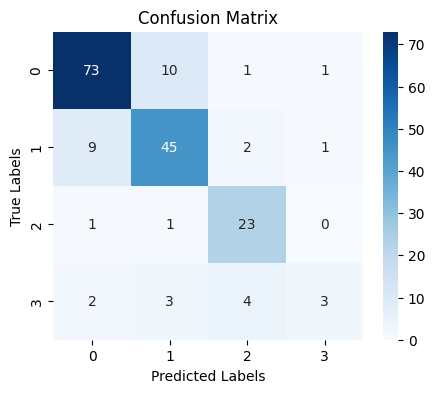

In [3]:
subj_index = "0558"
ind_558_acc, ind_558_f1 = predict_using_individual_model(subj_index)

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...Loading NoAugmenter augmenter...

Loading NoAugmenter augmenter...Loading NoAugmenter augmenter...

Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.785
F1-score (Macro): 0.401


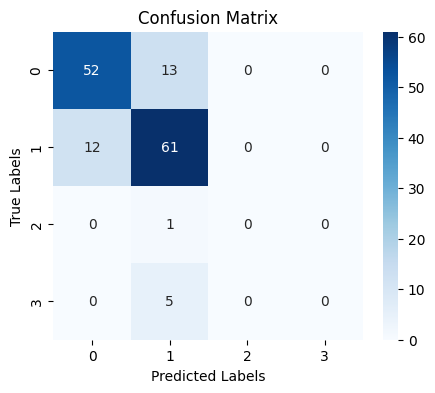

In [4]:
subj_index = "0565"
ind_565_acc, ind_565_f1 = predict_using_individual_model(subj_index)

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.622
F1-score (Macro): 0.317


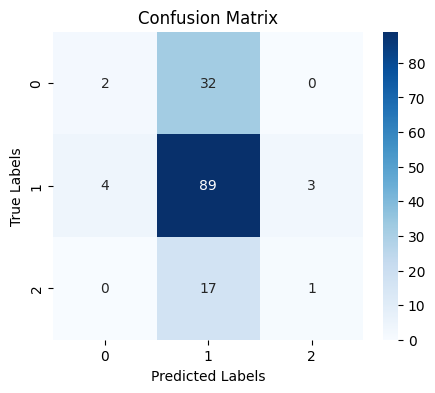

In [5]:
subj_index = "0560"
ind_560_acc, ind_560_f1 = predict_using_individual_model(subj_index)

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.736
F1-score (Macro): 0.595


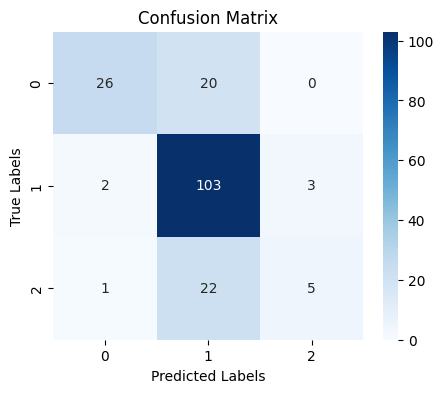

In [6]:
subj_index = "0571"
ind_571_acc, ind_571_f1 = predict_using_individual_model(subj_index)

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...Loading NoAugmenter augmenter...

Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.812
F1-score (Macro): 0.693


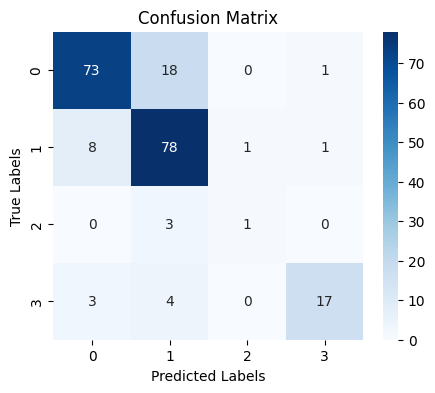

In [7]:
subj_index = "0583"
ind_583_acc, ind_583_f1 = predict_using_individual_model(subj_index)

### Individual Transfer Learning with Foundation Model

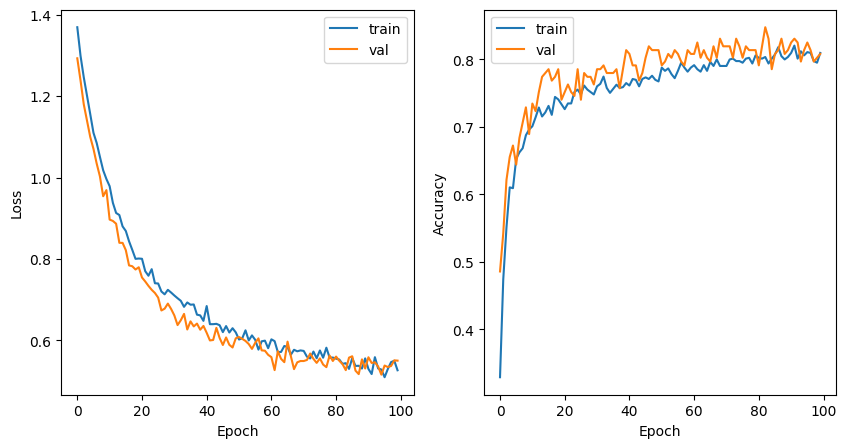

In [8]:
subj_index = "0558"
model_index = "0143"

loss_acc_plotting(subj_index, model_index)

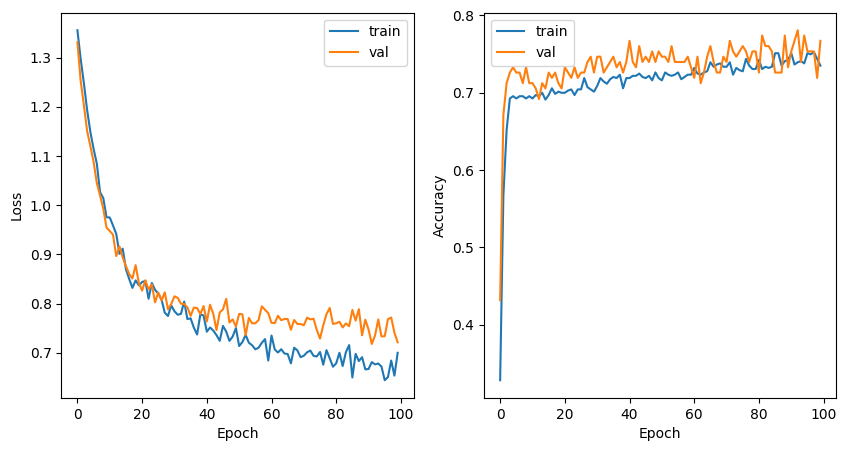

In [9]:
subj_index = "0560"
model_index = "0143"
loss_acc_plotting(subj_index, model_index)

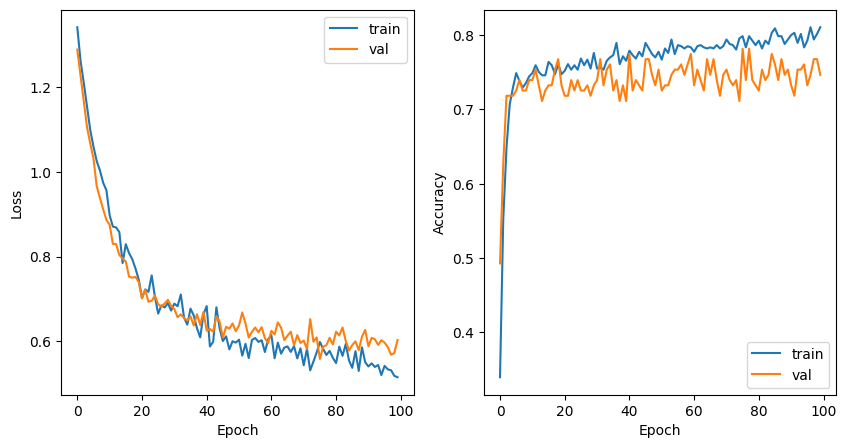

In [10]:
subj_index = "0565"
model_index = "0143"
loss_acc_plotting(subj_index, model_index)


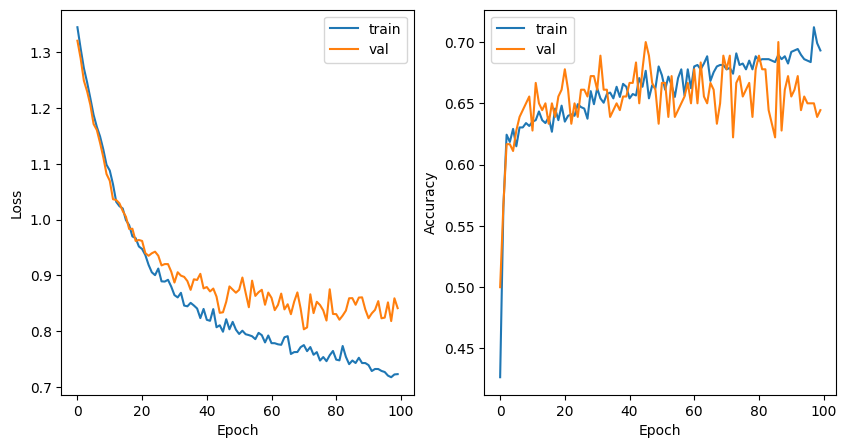

In [11]:
subj_index = "0571"
model_index = "0143"
loss_acc_plotting(subj_index, model_index)


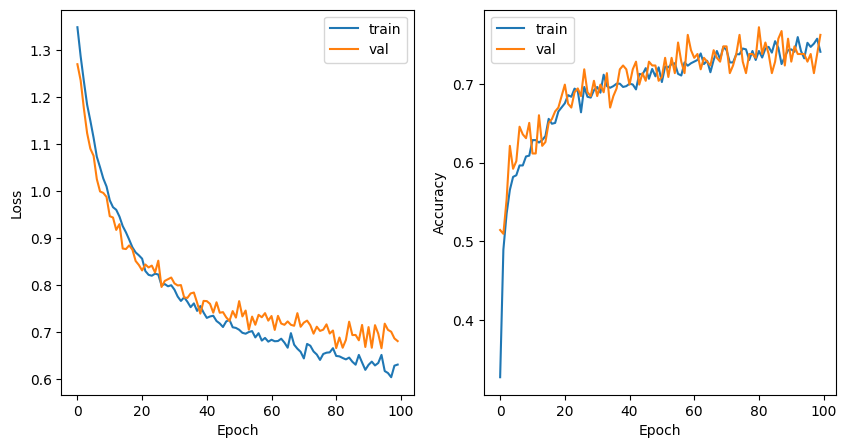

In [12]:
subj_index = "0583"
model_index = "0143"
loss_acc_plotting(subj_index, model_index)


### FM based Prediction Test

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.816
F1-score (Macro): 0.689


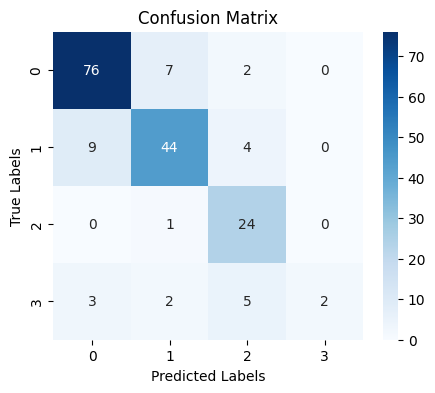

In [13]:
fm_558_acc, fm_558_f1 = predict_using_fm_classifier(subj_index="0558")

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.792
F1-score (Macro): 0.404


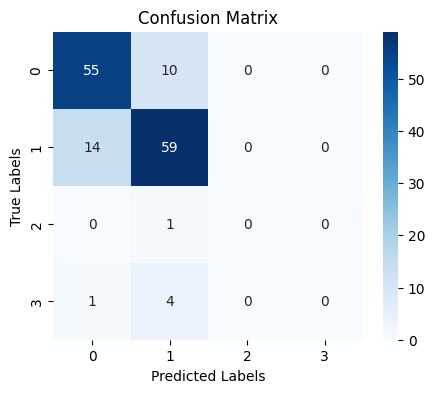

In [14]:
fm_565_acc, fm_565_f1 = predict_using_fm_classifier(subj_index="0565")

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.642
F1-score (Macro): 0.381


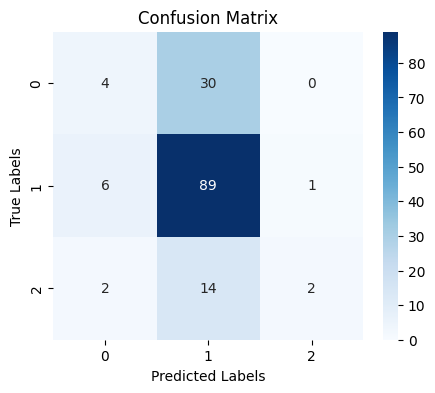

In [15]:
fm_560_acc, fm_560_f1 = predict_using_fm_classifier(subj_index="0560")

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.648
F1-score (Macro): 0.506


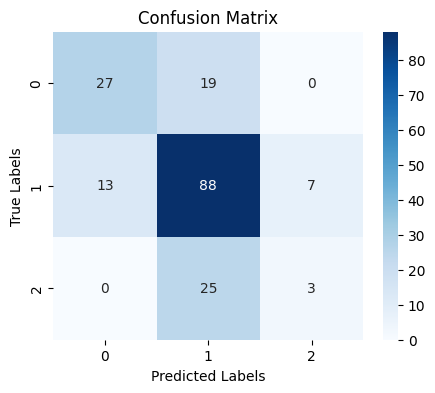

In [16]:
fm_571_acc, fm_571_f1 = predict_using_fm_classifier(subj_index="0571")

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...Loading NoAugmenter augmenter...

Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.716
F1-score (Macro): 0.52


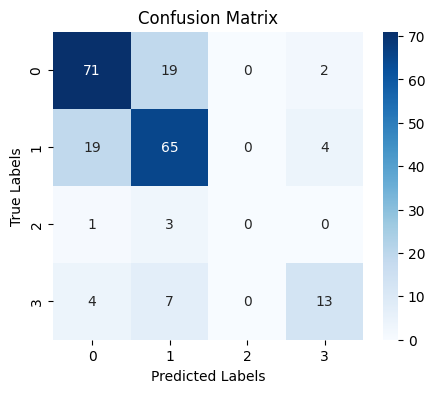

In [17]:
fm_583_acc, fm_583_f1 = predict_using_fm_classifier(subj_index="0583")

#### Compare individual Training VS. FM Training

In [18]:
print("Subject 0558")
print("----------------"*3)
print("Individual Model Accuracy: ", ind_558_acc)
print("*Foundation Model Accuracy: ", fm_558_acc)

print("Individual Model F1 Score: ", ind_558_f1)
print("*Foundation Model F1 Score: ", fm_558_f1)
print("----------------"*3)

if fm_558_acc > ind_558_acc:
    print("Foundation Model is better than Individual Model in terms of Accuracy")
    
if fm_558_f1 > ind_558_f1:
    print("Foundation Model is better than Individual Model in terms of F1 Score")

Subject 0558
------------------------------------------------
Individual Model Accuracy:  0.8044692737430168
*Foundation Model Accuracy:  0.8156424581005587
Individual Model F1 Score:  0.7059976028028766
*Foundation Model F1 Score:  0.689279948817521
------------------------------------------------
Foundation Model is better than Individual Model in terms of Accuracy


In [19]:
print("Subject 0565")
print("----------------"*3)
print("Individual Model Accuracy: ", ind_565_acc)
print("*Foundation Model Accuracy: ", fm_565_acc)

print("Individual Model F1 Score: ", ind_565_f1)
print("*Foundation Model F1 Score: ", fm_565_f1)
print("----------------"*3)

if fm_565_acc > ind_565_acc:
    print("Foundation Model is better than Individual Model in terms of Accuracy")

if fm_565_f1 > ind_565_f1:
    print("Foundation Model is better than Individual Model in terms of F1 Score")

Subject 0565
------------------------------------------------
Individual Model Accuracy:  0.7847222222222222
*Foundation Model Accuracy:  0.7916666666666666
Individual Model F1 Score:  0.4008967928256574
*Foundation Model F1 Score:  0.4043839758125472
------------------------------------------------
Foundation Model is better than Individual Model in terms of Accuracy
Foundation Model is better than Individual Model in terms of F1 Score


In [20]:
print("Subject 0560")
print("----------------"*3)
print("Individual Model Accuracy: ", ind_560_acc)
print("Foundation Model Accuracy: ", fm_560_acc)

print("Individual Model F1 Score: ", ind_560_f1)
print("Foundation Model F1 Score: ", fm_560_f1)
print("----------------"*3)

if fm_560_acc > ind_560_acc:
    print("Foundation Model is better than Individual Model in terms of Accuracy")
    
if fm_560_f1 > ind_560_f1:
    print("Foundation Model is better than Individual Model in terms of F1 Score")
    

Subject 0560
------------------------------------------------
Individual Model Accuracy:  0.6216216216216216
Foundation Model Accuracy:  0.6418918918918919
Individual Model F1 Score:  0.3171976171976172
Foundation Model F1 Score:  0.3805606034578885
------------------------------------------------
Foundation Model is better than Individual Model in terms of Accuracy
Foundation Model is better than Individual Model in terms of F1 Score


In [21]:
print("Subject 0571")
print("----------------"*3)
print("Individual Model Accuracy: ", ind_571_acc)
print("Foundation Model Accuracy: ", fm_571_acc)

print("Individual Model F1 Score: ", ind_571_f1)
print("Foundation Model F1 Score: ", fm_571_f1)
print("----------------"*3)

if fm_571_acc > ind_571_acc:
    print("Foundation Model is better than Individual Model in terms of Accuracy")
    
if fm_571_f1 > ind_571_f1:
    print("Foundation Model is better than Individual Model in terms of F1 Score")
    

Subject 0571
------------------------------------------------
Individual Model Accuracy:  0.7362637362637363
Foundation Model Accuracy:  0.6483516483516484
Individual Model F1 Score:  0.595113453374323
Foundation Model F1 Score:  0.5063783489732082
------------------------------------------------


In [22]:
print("Subject 0583")
print("----------------"*3)
print("Individual Model Accuracy: ", ind_583_acc)
print("Foundation Model Accuracy: ", fm_583_acc)

print("Individual Model F1 Score: ", ind_583_f1)
print("Foundation Model F1 Score: ", fm_583_f1)
print("----------------"*3)

if fm_571_acc > ind_583_acc:
    print("Foundation Model is better than Individual Model in terms of Accuracy")
    
if fm_571_f1 > ind_583_f1:
    print("Foundation Model is better than Individual Model in terms of F1 Score")
    

Subject 0583
------------------------------------------------
Individual Model Accuracy:  0.8125
Foundation Model Accuracy:  0.7163461538461539
Individual Model F1 Score:  0.6925825972497408
Foundation Model F1 Score:  0.5195737914616163
------------------------------------------------
